In [ ]:
pip install adversarial-robustness-toolbox

     |████████████████████████████████| 1.1 MB 4.3 MB/s 
     |████████████████████████████████| 3.3 MB 17.1 MB/s 
     |████████████████████████████████| 26.3 MB 50.5 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import art

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
def show_image(image, label=None):
  
  class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

  plt.figure(figsize=(15,15))
  plt.subplot(5,5,1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
  if label != None:
   plt.xlabel(class_names[label[0]])
  plt.show()


def get_label(model_prediction):
  """given the prediction of a model this function 
  prints out the associated label"""

  return class_names[np.argmax(model_prediction)]

def get_confidence(classifier, example):

  """Gets confidence levels for predictions"""
  
  pred = classifier.predict(example)
  label = np.argmax(pred,axis=1)
  confidence = np.max(pred, axis=1)

  print('label:',class_names[label[0]],'confidence:',confidence[0])

def get_attack_name(attack):
  """Returns attack name"""
  return str(attack).split('.')[3]

def get_attack_type(attack):
  """Returns attack type"""
  return str(attack).split('.')[2]
  
def get_defense_name(defense):
  """Returns defense name"""
  return str(defense).split('.')[3]

def get_defense_type(defense):
  """Returns defense type"""
  return str(defense).split('.')[2]

In [ ]:
#loading data
(x_train,y_train),(x_test,y_test) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 11s 0us/step


In [ ]:
#normalizing data
x_train = x_train/255
x_test = x_test/255

In [ ]:
#getting even number of classes and storing them in x_subsample and y_subsample
x_subsample = np.reshape(np.array([]),(0,32,32,3))
y_subsample = np.reshape(np.array([],dtype='int'),(0,1))

for i in range(len(np.unique(y_test))):
  
  index = (y_test==i).reshape(10000)
  x_subsample = np.append(x_subsample,x_test[index][18:28],axis=0)
  y_subsample = np.append(y_subsample, y_test[index][18:28],axis=0)

In [ ]:
#showing that there are 10 examples from each class
from collections import Counter

Counter(np.reshape(y_subsample,(100)))

Counter({0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10})

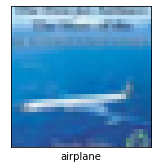

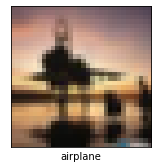

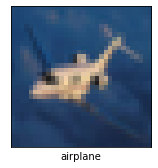

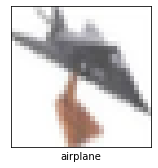

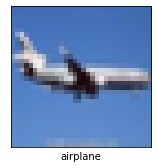

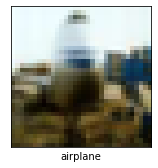

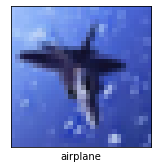

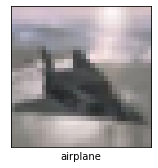

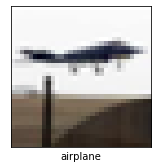

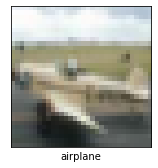

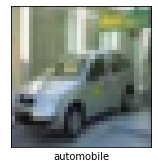

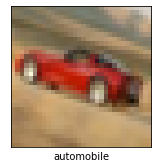

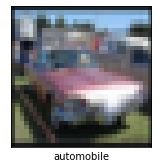

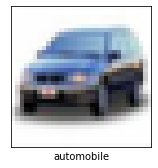

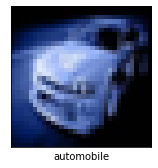

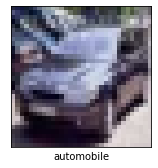

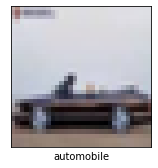

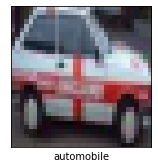

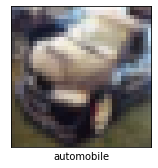

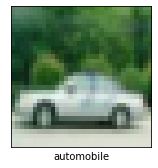

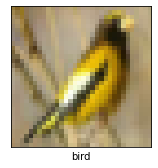

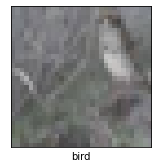

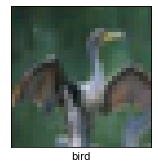

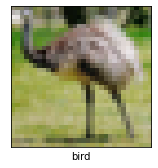

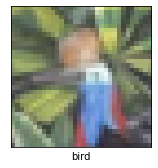

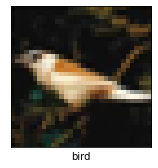

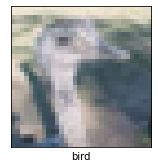

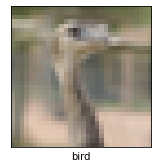

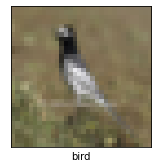

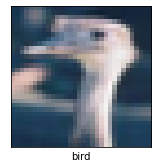

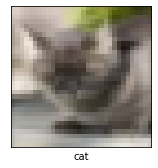

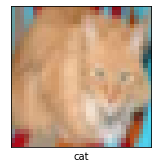

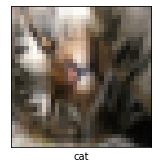

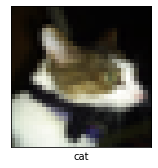

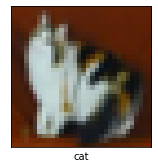

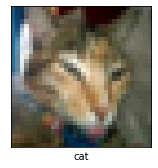

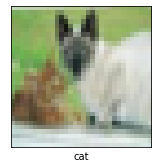

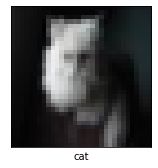

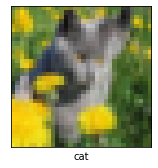

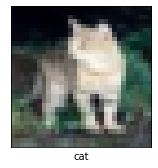

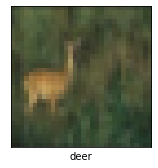

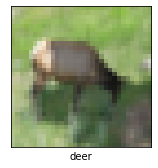

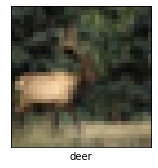

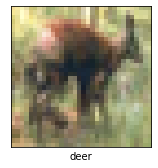

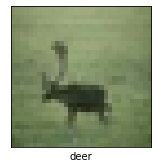

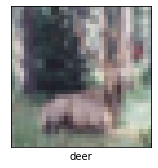

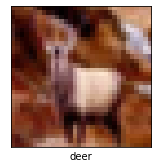

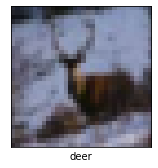

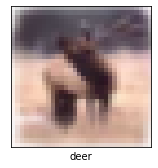

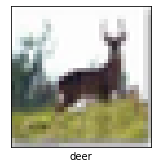

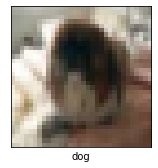

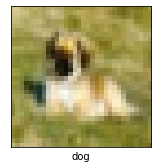

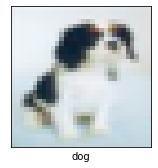

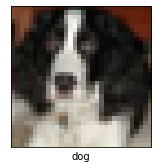

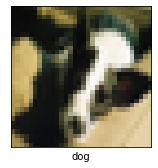

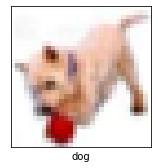

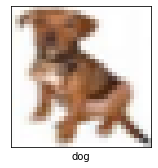

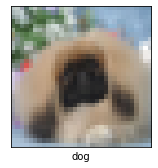

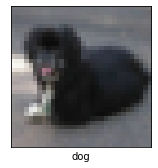

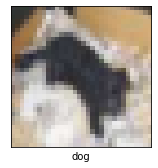

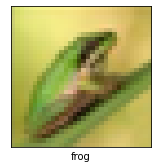

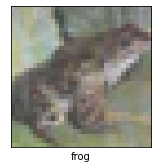

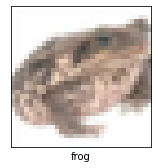

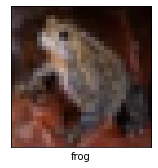

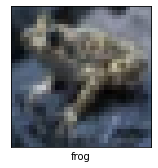

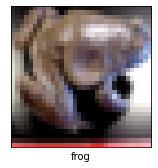

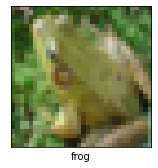

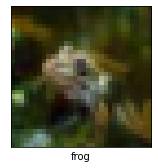

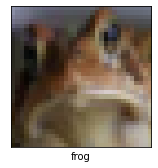

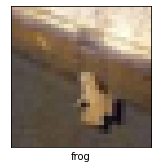

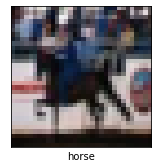

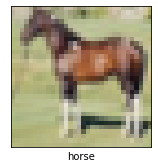

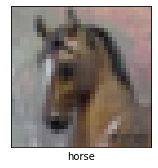

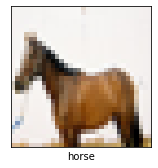

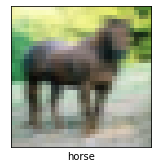

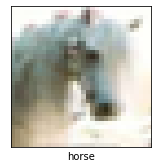

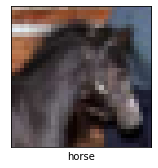

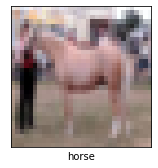

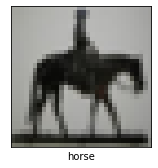

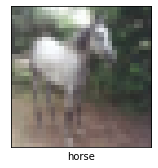

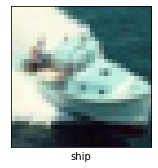

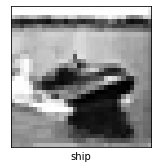

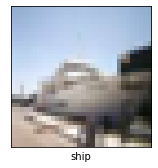

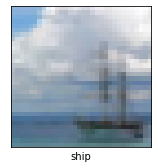

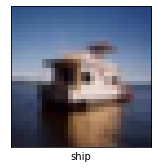

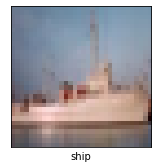

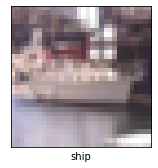

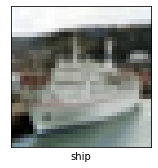

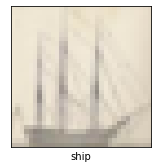

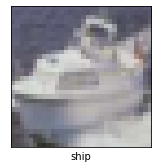

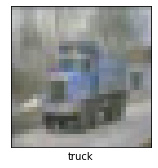

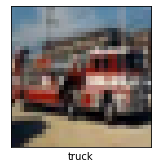

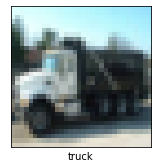

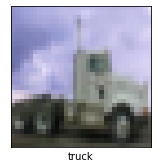

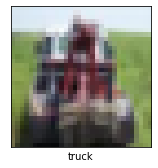

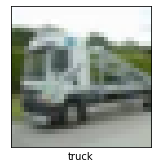

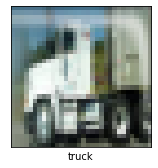

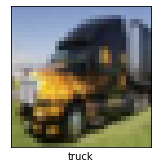

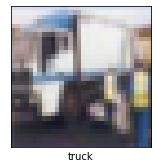

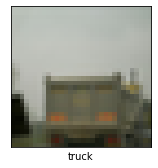

In [ ]:
#checking that the training examples match the labels chosen
for i in range(len(y_subsample)):
  show_image(x_subsample[i],y_subsample[i])

In [ ]:
print('feature_shape',x_subsample[0].shape)
print('label_shape',y_train[0].shape)

feature_shape (32, 32, 3)
label_shape (1,)


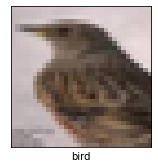

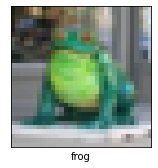

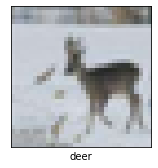

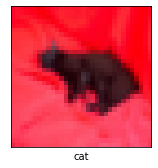

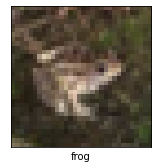

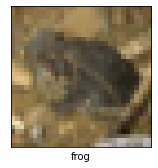

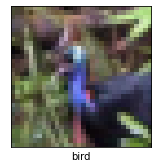

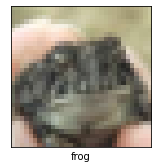

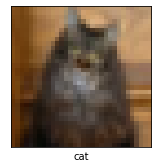

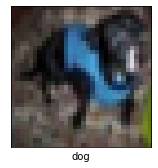

In [ ]:
#showing first 10 images 
for i in range(18,28):

  show_image(x_train[i],y_train[i])

In [ ]:
#loading victim model
victim_model = keras.Sequential([keras.layers.Input(shape=(32,32,3)),
                                 hub.KerasLayer("https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1",
                                 input_shape=(32,32,3),output_shape=(10),name='Victim_Model'),
                                 keras.layers.Softmax()
                                 ])

In [ ]:
#building victim model to expect input shape of (batch size, image_height, image_width, image_depth/num_channels)
victim_model.build(input_shape=(100,32,32,3))

In [ ]:
metrics = ['mae','accuracy',]#IGNORE

In [ ]:
victim_model.compile(keras.optimizers.SGD(momentum=0.9,learning_rate=0.1),
                     loss=keras.losses.binary_crossentropy,
                     metrics = metrics)

In [ ]:
#model summary
victim_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Victim_Model (KerasLayer)   (None, 10)                7796426   
                                                                 
 softmax (Softmax)           (None, 10)                0         
                                                                 
Total params: 7,796,426
Trainable params: 0
Non-trainable params: 7,796,426
_________________________________________________________________


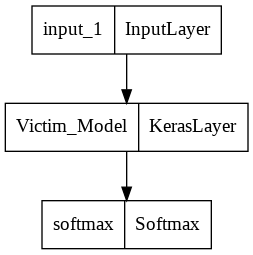

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(victim_model )

Classifier


In [ ]:
import art
classifier = art.estimators.classification.KerasClassifier(model = victim_model,clip_values=(0.,1.),use_logits=True)

Attack Function


In [ ]:
def perform_attack(attack, defenses = [], x=x_subsample, y=y_subsample, targeted=False):
  """Performs attack and show results.
  If defenses are provided it performs each defense and
  shows results."""

  #attack classifier
  #classifier = attack.classifier

  if targeted:
    y = targeted_labels

  #this routine is specific for adversarial patch examples
  if get_attack_name(attack)=='adversarial_patch':

    attack.generate(x)
    x_adversarial = adversarial_patch.apply_patch(x.copy(),0.3)
  
  
  else:
    x_adversarial = attack.generate(x,y)
    
  #metrics to measure 
  from sklearn.metrics import classification_report, accuracy_score
  from art.metrics import empirical_robustness

  
  #predictions without defense 
  attack_classifier_pred_originals =  np.argmax(classifier.predict(x),axis=1)
  attack_classifier_pred_adversarial =  np.argmax(classifier.predict(x_adversarial),axis=1)

  print('\nAttack effects on image\n==========================================================')

  #Showing visual impact
  for i in np.random.random_integers(0,99,3):
    print('\nBefore')
    show_image(x[i])
    get_confidence(classifier, np.expand_dims(x[i],0))

    print('\nAfter')
    show_image(x_adversarial[i])
    get_confidence(classifier, np.expand_dims(x_adversarial[i],0))

  print('\nPerformance w/ No Defense\n==========================================================================')
  print('performance on originals examples:\n','Accuracy:',accuracy_score(y_subsample, attack_classifier_pred_originals),'\n',classification_report(y_subsample, attack_classifier_pred_originals))

  print('performance on adversarial examples:\n','Accuracy:',accuracy_score(y_subsample, attack_classifier_pred_adversarial),'\n',classification_report(y_subsample, attack_classifier_pred_adversarial))

  print('\n======================================================================================')

  for defense in defenses:
    
    print('\nWith ',get_defense_name(defense),'defense applied\n===============================================================\n')

    #showing confidence before
    print('BEFORE DEFENSE')
    selected_images_idx = np.random.random_integers(0,99,1)

    for i in selected_images_idx:
      show_image(x[i])
      get_confidence(classifier, np.expand_dims(x[i],0))

    #mounting defense to classifier
    if get_defense_type(defense) == 'preprocessor':
      classifier.preprocessing_defences = [defense]
    elif get_defense_type(defense) == 'postprocessor':
      classifier.postprocessing_defences = [defense]

    #prediction with defenses 
    defense_classifier_pred_originals =  np.argmax(classifier.predict(x),axis=1)
    defense_classifier_pred_adversarial =  np.argmax(classifier.predict(x_adversarial),axis=1)

    #with defense applied
    print('\nPerformance on originals examples:\n','Accuracy:',accuracy_score(y_subsample,defense_classifier_pred_originals ),'\n',classification_report(y_subsample, defense_classifier_pred_originals))

    print('Performance on adversarial examples:\n','Accuracy:',accuracy_score(y_subsample, defense_classifier_pred_adversarial),'\n',classification_report(y_subsample, defense_classifier_pred_adversarial))

    print('\nWITH DEFENSE')
    #showing confidence after
    for i in selected_images_idx:
      show_image(x_adversarial[i])
      get_confidence(classifier, np.expand_dims(x_adversarial[i],0))

    #reset defence parameter to None
    classifier.preprocessing_defences = None
    classifier.postprocessing_defences = None

In [ ]:
targeted_labels = np.roll(y_subsample,20)

In [ ]:
import art.defences
from art.defences.preprocessor import GaussianAugmentation
from art.defences.postprocessor import ClassLabels
from art.defences.postprocessor import HighConfidence,ReverseSigmoid,Rounded
from art.defences.preprocessor import LabelSmoothing
from art.defences.preprocessor import FeatureSqueezing
from art.defences.preprocessor import SpatialSmoothing,PixelDefend,ThermometerEncoding,TotalVarMin
from art.defences.trainer import AdversarialTrainer,AdversarialTrainerMadryPGD,AdversarialTrainerFBF
from typing import List
from art.defences.transformer.evasion import DefensiveDistillation
from art.defences.detector.evasion import BinaryInputDetector,BinaryActivationDetector
from art.defences.detector.evasion.subsetscanning import SubsetScanningDetector

defenses = [GaussianAugmentation(augmentation=False, sigma=.02, apply_predict=True), 
            LabelSmoothing(max_value=.9),ClassLabels(),HighConfidence(cutoff=1.),FeatureSqueezing(clip_values=(0,1)),SpatialSmoothing(),ThermometerEncoding(clip_values=(0,1)),TotalVarMin(),ReverseSigmoid(),Rounded(decimals=2,apply_predict=True),
            AdversarialTrainerMadryPGD(classifier=classifier),DefensiveDistillation(classifier=classifier,nb_epochs=2),
            BinaryInputDetector(detector=classifier),BinaryActivationDetector(classifier=classifier,detector=classifier,layer=0)]

Elastic Net Attack


EAD:   0%|          | 0/4 [00:00<?, ?it/s]


Attack effects on image

Before


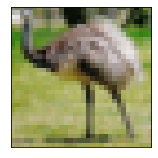

label: bird confidence: 0.9998828

After


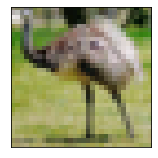

label: horse confidence: 0.53468055

Before


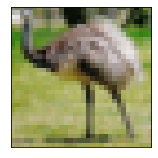

label: bird confidence: 0.9998828

After


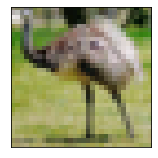

label: horse confidence: 0.53468055

Before


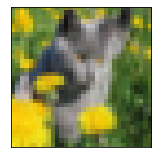

label: bird confidence: 0.6364619

After


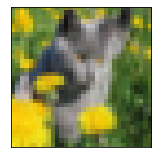

label: bird confidence: 0.6364619

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

performance on adversarial examples:
 Accuracy: 0.04 
               precision    recall  f1-score   support

           0     

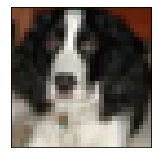

label: dog confidence: 0.99852633

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.04 
               precision    recall  f1-score   support

           0       0.12      0.20      0.15

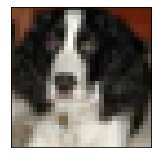

label: cat confidence: 0.6579996

With  label_smoothing defense applied

BEFORE DEFENSE


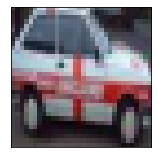

label: automobile confidence: 0.9600528

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.04 
               precision    recall  f1-score   support

           0       0.12      0.20    

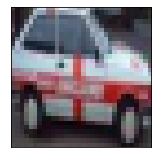

label: truck confidence: 0.5872839

With  class_labels defense applied

BEFORE DEFENSE


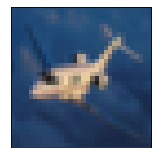

label: airplane confidence: 0.9999424

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.

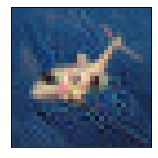

label: cat confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


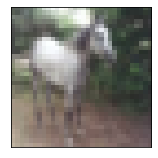

label: horse confidence: 0.99978405

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18

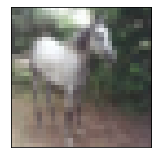

label: airplane confidence: 0.0

With  feature_squeezing defense applied

BEFORE DEFENSE


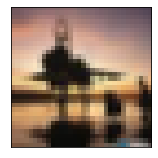

label: airplane confidence: 0.9863798

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.04 
               precision    recall  f1-score   support

           0       0.12      0.20      

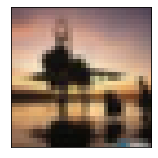

label: cat confidence: 0.40590554

With  spatial_smoothing defense applied

BEFORE DEFENSE


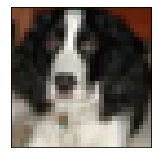

label: dog confidence: 0.99852633

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.04 
               precision    recall  f1-score   support

           0       0.12      0.20      0.15

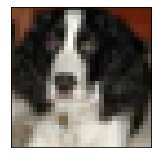

label: cat confidence: 0.6579996

With  thermometer_encoding defense applied

BEFORE DEFENSE


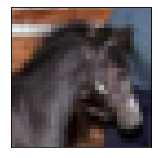

label: horse confidence: 0.995503

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.04 
               precision    recall  f1-score   support

           0       0.12      0.20      0.15

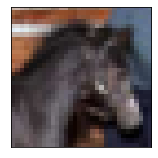

label: cat confidence: 0.5384842

With  variance_minimization defense applied

BEFORE DEFENSE


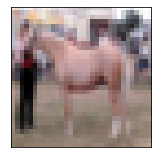

label: horse confidence: 0.99932027

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.04 
               precision    recall  f1-score   support

           0       0.12      0.20      0.

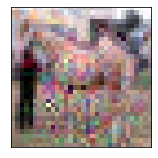

label: airplane confidence: 0.6374092

With  reverse_sigmoid defense applied

BEFORE DEFENSE


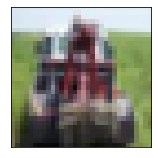

label: truck confidence: 0.5808423

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.04 
               precision    recall  f1-score   support

           0       0.12      0.20      0.1

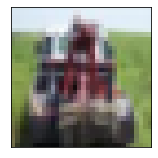

label: ship confidence: 0.16752155

With  rounded defense applied

BEFORE DEFENSE


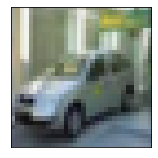

label: automobile confidence: 0.99938846

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.04 
               precision    recall  f1-score   support

           0       0.12      0.20   

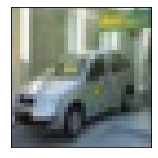

label: truck confidence: 0.88

With  adversarial_trainer_madry_pgd defense applied

BEFORE DEFENSE


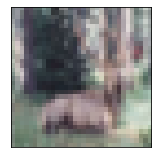

label: deer confidence: 0.98033464

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.04 
               precision    recall  f1-score   support

           0       0.12      0.20      0.1

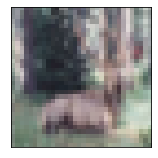

label: cat confidence: 0.54460853

With  evasion defense applied

BEFORE DEFENSE


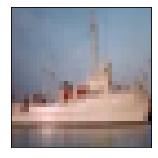

label: ship confidence: 0.9998871

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.04 
               precision    recall  f1-score   support

           0       0.12      0.20      0.15

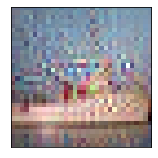

label: cat confidence: 0.74376553

With  0, std=1 defense applied

BEFORE DEFENSE


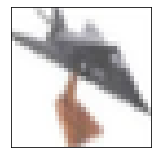

label: airplane confidence: 0.99961156

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.04 
               precision    recall  f1-score   support

           0       0.12      0.20     

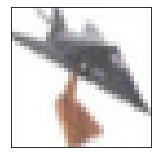

label: bird confidence: 0.6033784

With  0, std=1 defense applied

BEFORE DEFENSE


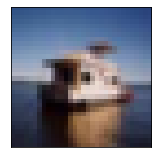

label: ship confidence: 0.9676307

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.04 
               precision    recall  f1-score   support

           0       0.12      0.20      0.15

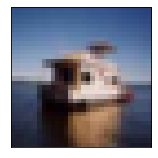

label: bird confidence: 0.7019536

                                                 TARGETED ATTACK                                                



EAD:   0%|          | 0/4 [00:00<?, ?it/s]


Attack effects on image

Before


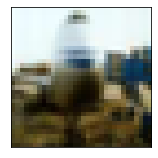

label: airplane confidence: 0.98980546

After


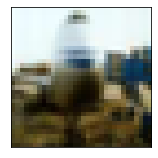

label: airplane confidence: 0.98980546

Before


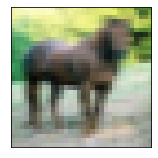

label: horse confidence: 0.98557013

After


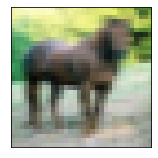

label: horse confidence: 0.98557013

Before


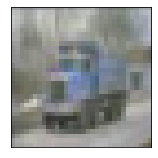

label: truck confidence: 0.99986684

After


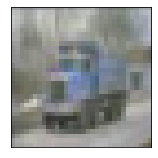

label: truck confidence: 0.99986684

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0    

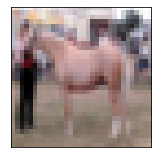

label: horse confidence: 0.99932027

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.0

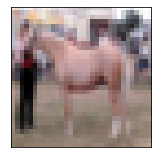

label: horse confidence: 0.99932027

With  label_smoothing defense applied

BEFORE DEFENSE


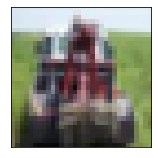

label: truck confidence: 0.5808423

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00

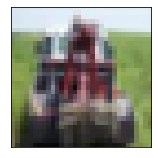

label: truck confidence: 0.5808423

With  class_labels defense applied

BEFORE DEFENSE


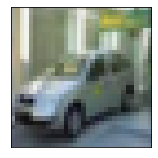

label: automobile confidence: 0.99938846

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00     

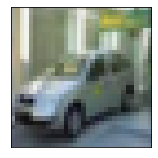

label: automobile confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


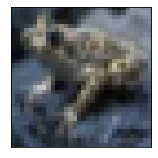

label: frog confidence: 0.9991872

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18  

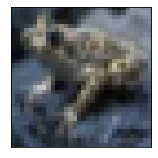

label: airplane confidence: 0.0

With  feature_squeezing defense applied

BEFORE DEFENSE


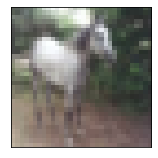

label: horse confidence: 0.99978405

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.0

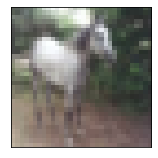

label: horse confidence: 0.99978405

With  spatial_smoothing defense applied

BEFORE DEFENSE


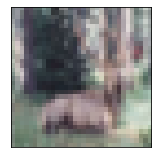

label: deer confidence: 0.98033464

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00

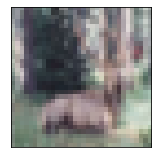

label: deer confidence: 0.98033464

With  thermometer_encoding defense applied

BEFORE DEFENSE


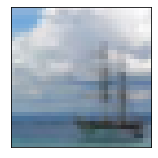

label: ship confidence: 0.99998903

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00

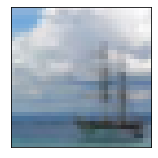

label: ship confidence: 0.99998903

With  variance_minimization defense applied

BEFORE DEFENSE


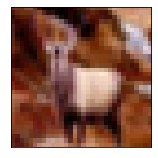

label: deer confidence: 0.86077994

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00

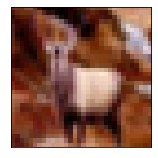

label: deer confidence: 0.86077994

With  reverse_sigmoid defense applied

BEFORE DEFENSE


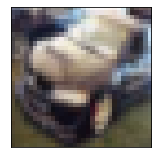

label: automobile confidence: 0.998884

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      

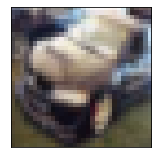

label: automobile confidence: 0.26091987

With  rounded defense applied

BEFORE DEFENSE


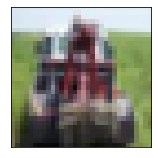

label: truck confidence: 0.5808423

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00      1.0

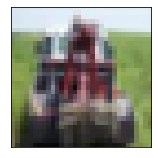

label: truck confidence: 0.58

With  adversarial_trainer_madry_pgd defense applied

BEFORE DEFENSE


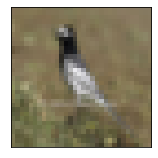

label: bird confidence: 0.9999212

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00 

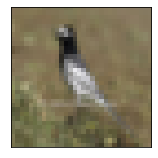

label: bird confidence: 0.9999212

With  evasion defense applied

BEFORE DEFENSE


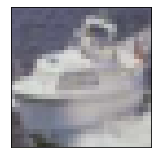

label: ship confidence: 0.99994326

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00

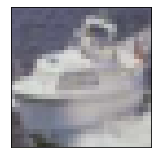

label: ship confidence: 0.99994326

With  0, std=1 defense applied

BEFORE DEFENSE


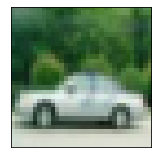

label: automobile confidence: 0.9998956

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00     

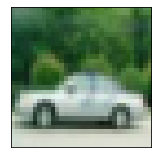

label: automobile confidence: 0.9998956

With  0, std=1 defense applied

BEFORE DEFENSE


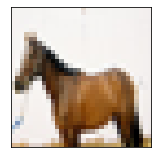

label: horse confidence: 0.9995067

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00

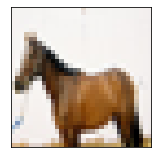

label: horse confidence: 0.9995067


In [ ]:
from art.attacks.evasion import ElasticNet
elastic_net = ElasticNet(classifier=classifier,batch_size=32,max_iter=1,learning_rate=0.1,)
elastic_net_targeted = ElasticNet(classifier=classifier,batch_size=32,max_iter=5,learning_rate=0.1,targeted=True)
perform_attack(elastic_net, defenses)
print('                                                 TARGETED ATTACK                                                ')
perform_attack(elastic_net_targeted, defenses)

Newton fool Attack


NewtonFool:   0%|          | 0/4 [00:00<?, ?it/s]


Attack effects on image

Before


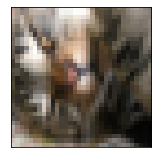

label: cat confidence: 0.62254846

After


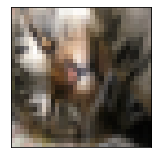

label: dog confidence: 0.60703576

Before


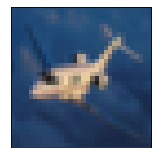

label: airplane confidence: 0.9999424

After


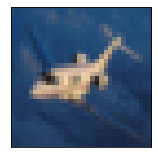

label: airplane confidence: 0.9739647

Before


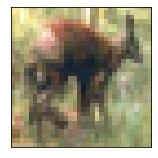

label: deer confidence: 0.9998934

After


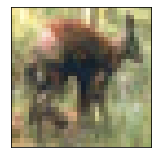

label: dog confidence: 0.6771535

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

performance on adversarial examples:
 Accuracy: 0.39 
               precision    recall  f1-score   support

           0      

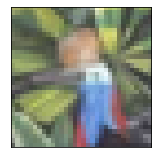

label: bird confidence: 0.99915814

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.39 
               precision    recall  f1-score   support

           0       0.50      0.30      0.3

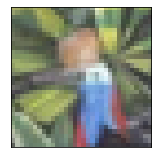

label: bird confidence: 0.9517355

With  label_smoothing defense applied

BEFORE DEFENSE


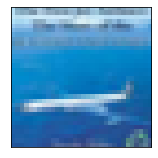

label: airplane confidence: 0.9935533

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.39 
               precision    recall  f1-score   support

           0       0.50      0.30      

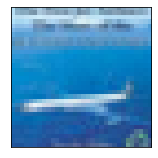

label: ship confidence: 0.8736549

With  class_labels defense applied

BEFORE DEFENSE


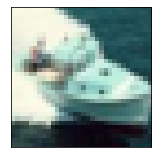

label: ship confidence: 0.999892

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18   

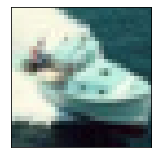

label: ship confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


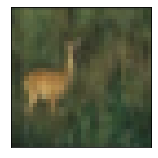

label: deer confidence: 0.99988663

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18 

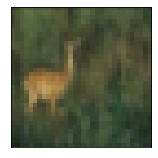

label: airplane confidence: 0.0

With  feature_squeezing defense applied

BEFORE DEFENSE


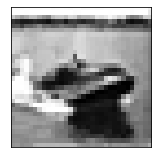

label: ship confidence: 0.99965477

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.39 
               precision    recall  f1-score   support

           0       0.50      0.30      0.3

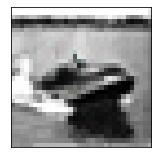

label: airplane confidence: 0.7859988

With  spatial_smoothing defense applied

BEFORE DEFENSE


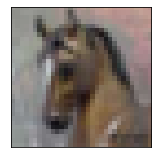

label: horse confidence: 0.99986064

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.39 
               precision    recall  f1-score   support

           0       0.50      0.30      0.

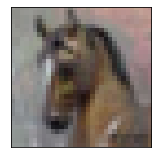

label: cat confidence: 0.9996877

With  thermometer_encoding defense applied

BEFORE DEFENSE


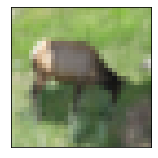

label: deer confidence: 0.9998647

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.39 
               precision    recall  f1-score   support

           0       0.50      0.30      0.37

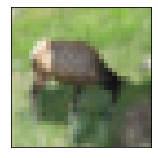

label: bird confidence: 0.97061

With  variance_minimization defense applied

BEFORE DEFENSE


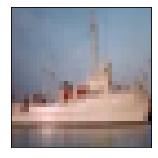

label: ship confidence: 0.9998871

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.39 
               precision    recall  f1-score   support

           0       0.50      0.30      0.37

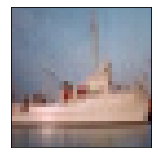

label: ship confidence: 0.99380046

With  reverse_sigmoid defense applied

BEFORE DEFENSE


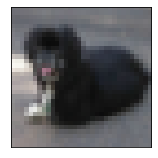

label: dog confidence: 0.9984774

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.39 
               precision    recall  f1-score   support

           0       0.50      0.30      0.37 

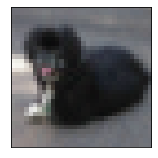

label: cat confidence: 0.34229362

With  rounded defense applied

BEFORE DEFENSE


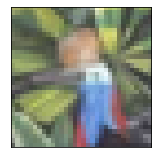

label: bird confidence: 0.99915814

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.39 
               precision    recall  f1-score   support

           0       0.50      0.30      0.3

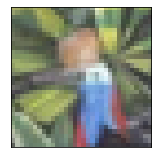

label: bird confidence: 0.95

With  adversarial_trainer_madry_pgd defense applied

BEFORE DEFENSE


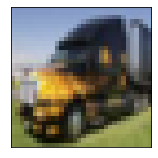

label: truck confidence: 0.9995741

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.39 
               precision    recall  f1-score   support

           0       0.50      0.30      0.3

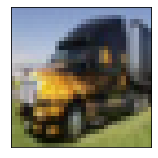

label: automobile confidence: 0.6385187

With  evasion defense applied

BEFORE DEFENSE


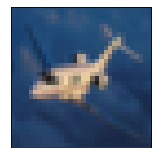

label: airplane confidence: 0.9999424

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.39 
               precision    recall  f1-score   support

           0       0.50      0.30      

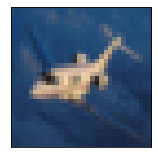

label: airplane confidence: 0.9739647

With  0, std=1 defense applied

BEFORE DEFENSE


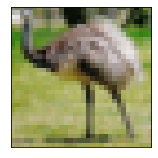

label: bird confidence: 0.9998828

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.39 
               precision    recall  f1-score   support

           0       0.50      0.30      0.37

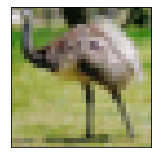

label: horse confidence: 0.6309349

With  0, std=1 defense applied

BEFORE DEFENSE


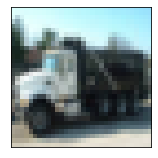

label: truck confidence: 0.99999475

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.39 
               precision    recall  f1-score   support

           0       0.50      0.30      0.

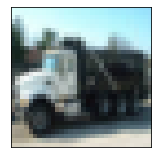

label: truck confidence: 0.9999273


In [ ]:
from art.attacks.evasion import NewtonFool

newton_fool = NewtonFool(classifier=classifier,batch_size=32,max_iter=1)

perform_attack(newton_fool, defenses)

Fast Gradient Method


Attack effects on image

Before


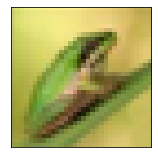

label: frog confidence: 0.9998716

After


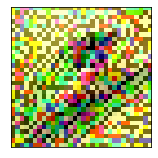

label: truck confidence: 0.72098786

Before


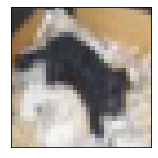

label: cat confidence: 0.9383735

After


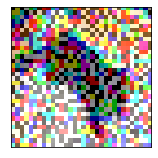

label: truck confidence: 0.48444423

Before


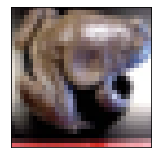

label: frog confidence: 0.98686534

After


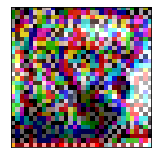

label: airplane confidence: 0.5778118

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

performance on adversarial examples:
 Accuracy: 0.11 
               precision    recall  f1-score   support

           0 

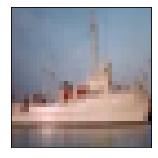

label: ship confidence: 0.9998871

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.11 
               precision    recall  f1-score   support

           0       0.06      0.10      0.07

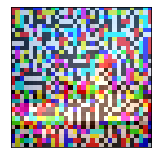

label: cat confidence: 0.5859942

With  label_smoothing defense applied

BEFORE DEFENSE


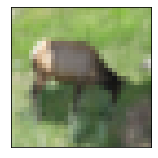

label: deer confidence: 0.9998647

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.11 
               precision    recall  f1-score   support

           0       0.06      0.10      0.07

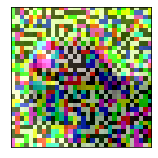

label: bird confidence: 0.8477854

With  class_labels defense applied

BEFORE DEFENSE


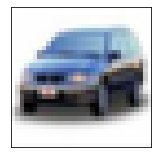

label: automobile confidence: 0.9999989

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      

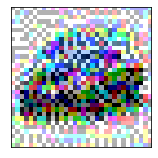

label: cat confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


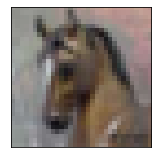

label: horse confidence: 0.99986064

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18

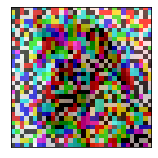

label: airplane confidence: 0.0

With  feature_squeezing defense applied

BEFORE DEFENSE


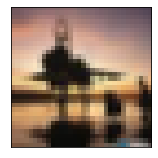

label: airplane confidence: 0.9863798

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.11 
               precision    recall  f1-score   support

           0       0.06      0.10      

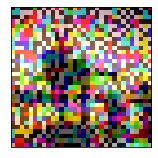

label: truck confidence: 0.89213383

With  spatial_smoothing defense applied

BEFORE DEFENSE


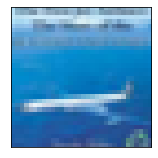

label: airplane confidence: 0.9935533

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.11 
               precision    recall  f1-score   support

           0       0.06      0.10      

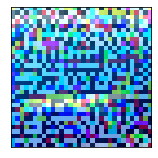

label: truck confidence: 0.61953884

With  thermometer_encoding defense applied

BEFORE DEFENSE


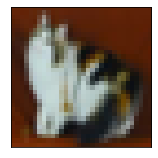

label: cat confidence: 0.99208164

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.11 
               precision    recall  f1-score   support

           0       0.06      0.10      0.07

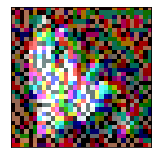

label: airplane confidence: 0.42611453

With  variance_minimization defense applied

BEFORE DEFENSE


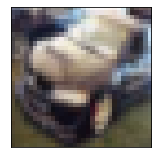

label: automobile confidence: 0.998884

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.11 
               precision    recall  f1-score   support

           0       0.06      0.10     

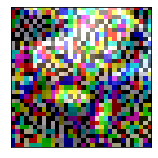

label: bird confidence: 0.99742186

With  reverse_sigmoid defense applied

BEFORE DEFENSE


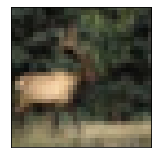

label: deer confidence: 0.99808913

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.11 
               precision    recall  f1-score   support

           0       0.06      0.10      0.0

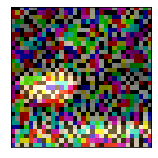

label: cat confidence: 0.19652785

With  rounded defense applied

BEFORE DEFENSE


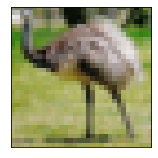

label: bird confidence: 0.9998828

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.11 
               precision    recall  f1-score   support

           0       0.06      0.10      0.07

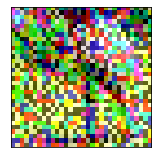

label: airplane confidence: 0.86

With  adversarial_trainer_madry_pgd defense applied

BEFORE DEFENSE


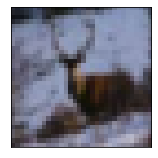

label: deer confidence: 0.9989409

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.11 
               precision    recall  f1-score   support

           0       0.06      0.10      0.07

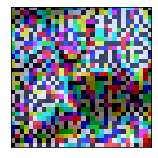

label: automobile confidence: 0.9138459

With  evasion defense applied

BEFORE DEFENSE


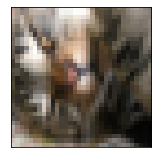

label: cat confidence: 0.62254846

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.11 
               precision    recall  f1-score   support

           0       0.06      0.10      0.07

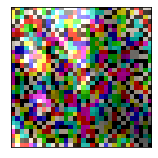

label: bird confidence: 0.728608

With  0, std=1 defense applied

BEFORE DEFENSE


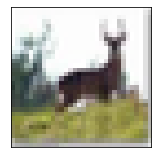

label: deer confidence: 0.99752337

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.11 
               precision    recall  f1-score   support

           0       0.06      0.10      0.0

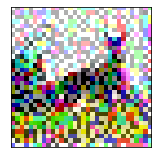

label: cat confidence: 0.37735602

With  0, std=1 defense applied

BEFORE DEFENSE


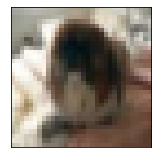

label: dog confidence: 0.99083734

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.11 
               precision    recall  f1-score   support

           0       0.06      0.10      0.07

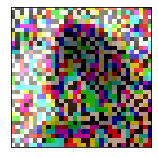

label: truck confidence: 0.8838325

                                                 TARGETED ATTACK                                                


Attack effects on image

Before


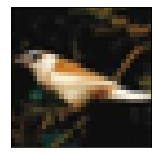

label: bird confidence: 0.99927574

After


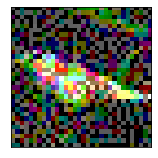

label: frog confidence: 0.94751865

Before


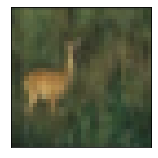

label: deer confidence: 0.99988663

After


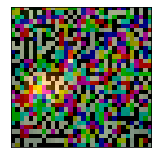

label: frog confidence: 0.9598298

Before


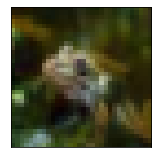

label: frog confidence: 0.9997274

After


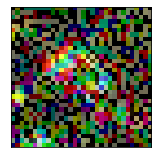

label: frog confidence: 0.978873

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

performance on adversarial examples:
 Accuracy: 0.12 
               precision    recall  f1-score   support

           0      

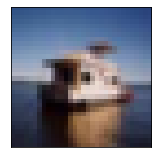

label: ship confidence: 0.9676307

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.12 
               precision    recall  f1-score   support

           0       0.08      0.10      0.09

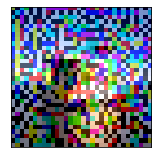

label: truck confidence: 0.6988628

With  label_smoothing defense applied

BEFORE DEFENSE


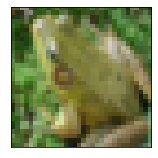

label: frog confidence: 0.9998198

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.12 
               precision    recall  f1-score   support

           0       0.08      0.10      0.09

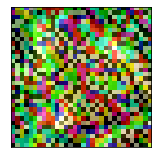

label: frog confidence: 0.75655043

With  class_labels defense applied

BEFORE DEFENSE


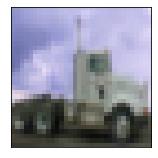

label: truck confidence: 0.998872

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18  

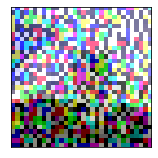

label: truck confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


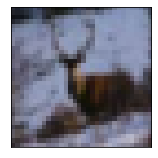

label: deer confidence: 0.9989409

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18  

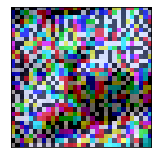

label: airplane confidence: 0.0

With  feature_squeezing defense applied

BEFORE DEFENSE


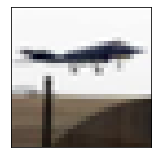

label: airplane confidence: 0.9974567

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.12 
               precision    recall  f1-score   support

           0       0.08      0.10      

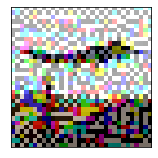

label: cat confidence: 0.8988462

With  spatial_smoothing defense applied

BEFORE DEFENSE


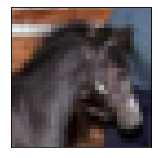

label: horse confidence: 0.995503

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.12 
               precision    recall  f1-score   support

           0       0.08      0.10      0.09

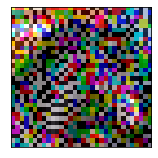

label: truck confidence: 0.91055155

With  thermometer_encoding defense applied

BEFORE DEFENSE


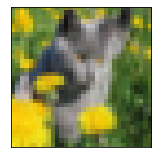

label: bird confidence: 0.6364619

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.12 
               precision    recall  f1-score   support

           0       0.08      0.10      0.09

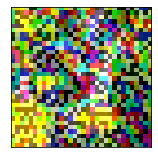

label: cat confidence: 0.7266085

With  variance_minimization defense applied

BEFORE DEFENSE


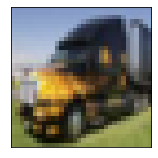

label: truck confidence: 0.9995741

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.12 
               precision    recall  f1-score   support

           0       0.08      0.10      0.0

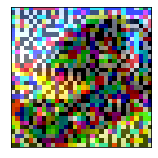

label: truck confidence: 0.9724822

With  reverse_sigmoid defense applied

BEFORE DEFENSE


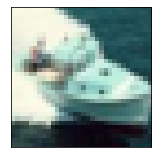

label: ship confidence: 0.999892

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.12 
               precision    recall  f1-score   support

           0       0.08      0.10      0.09 

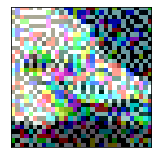

label: truck confidence: 0.30029446

With  rounded defense applied

BEFORE DEFENSE


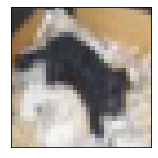

label: cat confidence: 0.9383735

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.12 
               precision    recall  f1-score   support

           0       0.08      0.10      0.09 

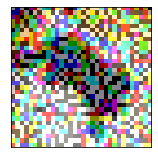

label: cat confidence: 0.92

With  adversarial_trainer_madry_pgd defense applied

BEFORE DEFENSE


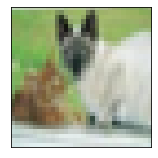

label: cat confidence: 0.9339586

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.12 
               precision    recall  f1-score   support

           0       0.08      0.10      0.09 

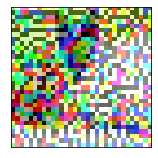

label: airplane confidence: 0.34653613

With  evasion defense applied

BEFORE DEFENSE


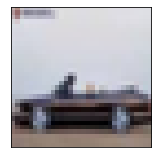

label: automobile confidence: 0.90567017

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.12 
               precision    recall  f1-score   support

           0       0.08      0.10   

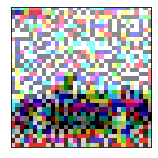

label: cat confidence: 0.64626324

With  0, std=1 defense applied

BEFORE DEFENSE


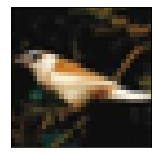

label: bird confidence: 0.99927574

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.12 
               precision    recall  f1-score   support

           0       0.08      0.10      0.0

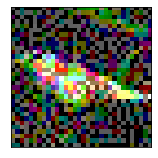

label: frog confidence: 0.94751865

With  0, std=1 defense applied

BEFORE DEFENSE


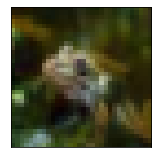

label: frog confidence: 0.9997274

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.12 
               precision    recall  f1-score   support

           0       0.08      0.10      0.09

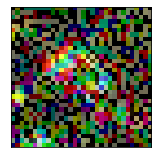

label: frog confidence: 0.978873


In [ ]:
from art.attacks.evasion import FastGradientMethod
fast_gradient_method = FastGradientMethod(estimator=classifier,batch_size=32)
fast_gradient_method_targeted = FastGradientMethod(estimator=classifier,batch_size=32,targeted=True)
perform_attack(fast_gradient_method, defenses)
print('                                                 TARGETED ATTACK                                                ')
perform_attack(fast_gradient_method_targeted, defenses)

Basic iterative Attack

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]


Attack effects on image

Before


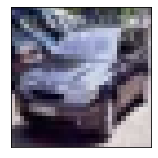

label: automobile confidence: 0.99983346

After


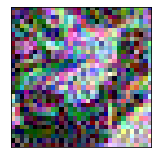

label: frog confidence: 1.0

Before


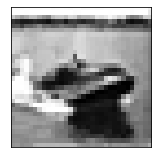

label: ship confidence: 0.99965477

After


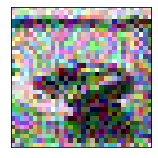

label: bird confidence: 1.0

Before


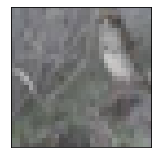

label: bird confidence: 0.98954624

After


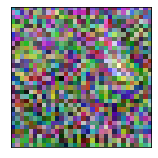

label: frog confidence: 0.9999999

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0      

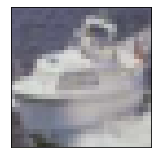

label: ship confidence: 0.99994326

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00

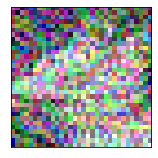

label: frog confidence: 1.0

With  label_smoothing defense applied

BEFORE DEFENSE


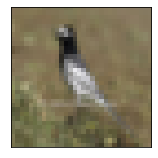

label: bird confidence: 0.9999212

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00 

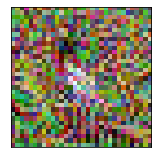

label: frog confidence: 0.9999988

With  class_labels defense applied

BEFORE DEFENSE


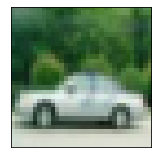

label: automobile confidence: 0.9998956

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.00      0.00      

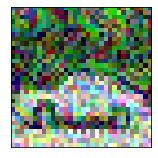

label: frog confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


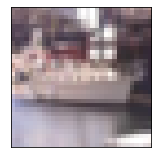

label: ship confidence: 0.9374856

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.08 
               precision    recall  f1-score   support

           0       0.14      0.80      0.23 

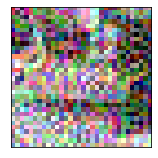

label: frog confidence: 1.0

With  feature_squeezing defense applied

BEFORE DEFENSE


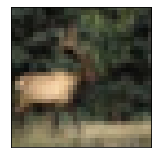

label: deer confidence: 0.99808913

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00

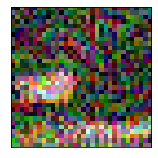

label: frog confidence: 0.9999989

With  spatial_smoothing defense applied

BEFORE DEFENSE


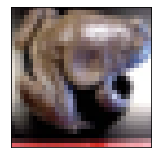

label: frog confidence: 0.98686534

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00

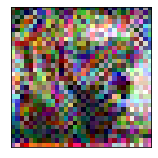

label: bird confidence: 0.99999976

With  thermometer_encoding defense applied

BEFORE DEFENSE


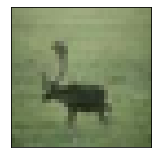

label: deer confidence: 0.9893441

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00 

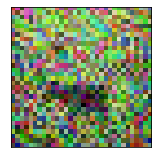

label: frog confidence: 0.9999995

With  variance_minimization defense applied

BEFORE DEFENSE


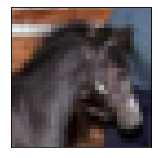

label: horse confidence: 0.995503

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00 

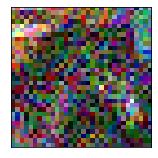

label: bird confidence: 0.9999994

With  reverse_sigmoid defense applied

BEFORE DEFENSE


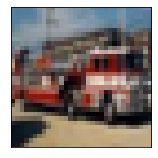

label: truck confidence: 0.9999064

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00

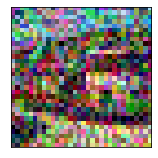

label: frog confidence: 0.12563011

With  rounded defense applied

BEFORE DEFENSE


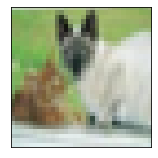

label: cat confidence: 0.9339586

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00  

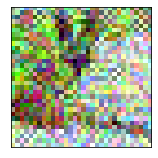

label: bird confidence: 1.0

With  adversarial_trainer_madry_pgd defense applied

BEFORE DEFENSE


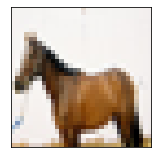

label: horse confidence: 0.9995067

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00

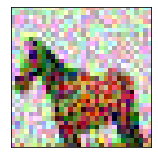

label: frog confidence: 0.99999714

With  evasion defense applied

BEFORE DEFENSE


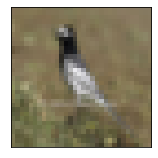

label: bird confidence: 0.9999212

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00 

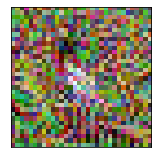

label: frog confidence: 0.9999988

With  0, std=1 defense applied

BEFORE DEFENSE


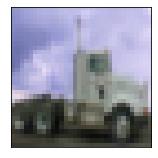

label: truck confidence: 0.998872

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00 

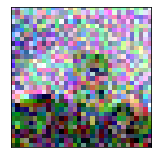

label: frog confidence: 1.0

With  0, std=1 defense applied

BEFORE DEFENSE


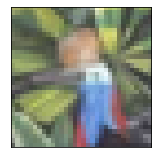

label: bird confidence: 0.99915814

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00

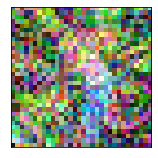

label: frog confidence: 1.0
                                                 TARGETED ATTACK                                                


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]


Attack effects on image

Before


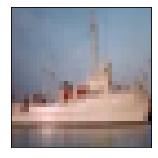

label: ship confidence: 0.9998871

After


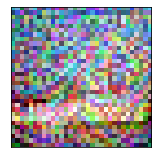

label: ship confidence: 0.999998

Before


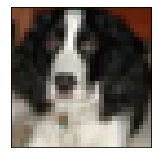

label: dog confidence: 0.99852633

After


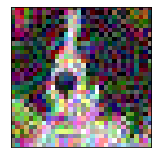

label: dog confidence: 1.0

Before


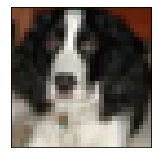

label: dog confidence: 0.99852633

After


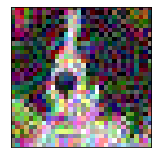

label: dog confidence: 1.0

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00 

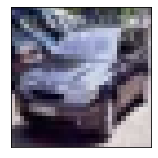

label: automobile confidence: 0.99983346

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00   

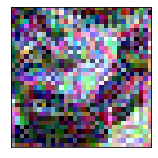

label: automobile confidence: 0.99971

With  label_smoothing defense applied

BEFORE DEFENSE


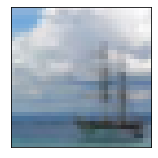

label: ship confidence: 0.99998903

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00      1.0

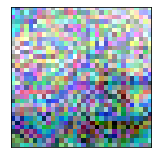

label: ship confidence: 0.9998497

With  class_labels defense applied

BEFORE DEFENSE


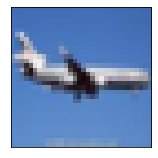

label: airplane confidence: 0.99994016

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0

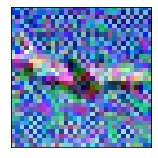

label: airplane confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


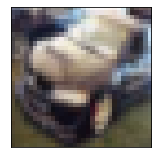

label: automobile confidence: 0.998884

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.57 
               precision    recall  f1-score   support

           0       0.19      1.00      

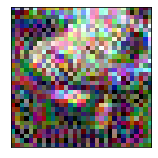

label: automobile confidence: 1.0

With  feature_squeezing defense applied

BEFORE DEFENSE


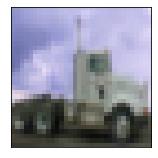

label: truck confidence: 0.998872

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00

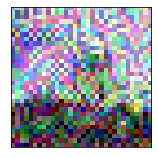

label: truck confidence: 1.0

With  spatial_smoothing defense applied

BEFORE DEFENSE


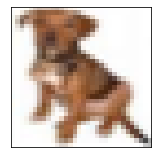

label: dog confidence: 0.99998534

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00

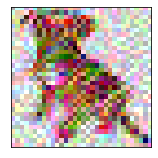

label: dog confidence: 1.0

With  thermometer_encoding defense applied

BEFORE DEFENSE


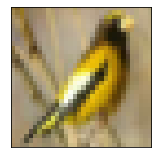

label: bird confidence: 0.9995808

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00

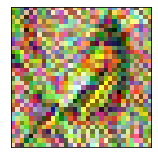

label: bird confidence: 0.99995816

With  variance_minimization defense applied

BEFORE DEFENSE


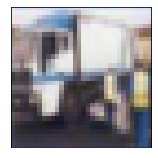

label: truck confidence: 0.9998945

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00      1.0

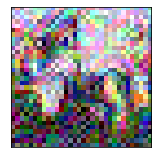

label: truck confidence: 1.0

With  reverse_sigmoid defense applied

BEFORE DEFENSE


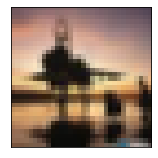

label: airplane confidence: 0.9863798

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00      

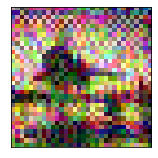

label: airplane confidence: 0.12749812

With  rounded defense applied

BEFORE DEFENSE


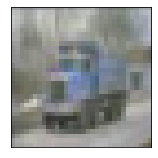

label: truck confidence: 0.99986684

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00      1.

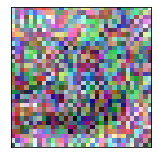

label: truck confidence: 1.0

With  adversarial_trainer_madry_pgd defense applied

BEFORE DEFENSE


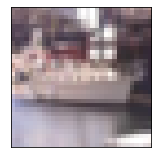

label: ship confidence: 0.9374856

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00

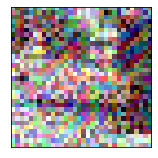

label: ship confidence: 0.99999595

With  evasion defense applied

BEFORE DEFENSE


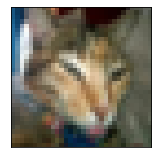

label: cat confidence: 0.999742

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00  

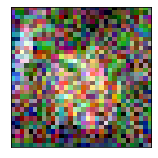

label: cat confidence: 0.99999976

With  0, std=1 defense applied

BEFORE DEFENSE


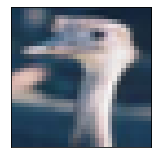

label: bird confidence: 0.99977463

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00      1.0

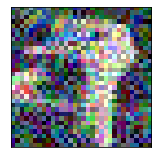

label: bird confidence: 0.99999905

With  0, std=1 defense applied

BEFORE DEFENSE


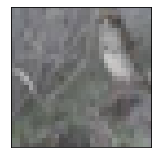

label: bird confidence: 0.98954624

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00      1.0

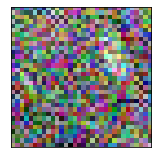

label: bird confidence: 0.99999964


In [ ]:
from art.attacks.evasion import BasicIterativeMethod

basic_iterative = BasicIterativeMethod(estimator=classifier,batch_size=32)
basic_iterative_targeted = BasicIterativeMethod(estimator=classifier,batch_size=32,targeted=True)

perform_attack(basic_iterative, defenses)
print('                                                 TARGETED ATTACK                                                ')
perform_attack(basic_iterative_targeted, defenses)

Deep fool attack

DeepFool:   0%|          | 0/4 [00:00<?, ?it/s]


Attack effects on image

Before


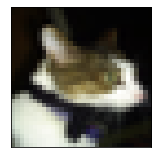

label: cat confidence: 0.99184376

After


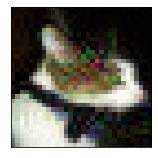

label: bird confidence: 0.9711158

Before


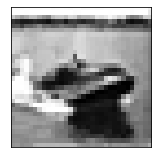

label: ship confidence: 0.99965477

After


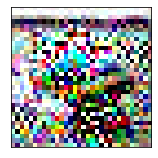

label: airplane confidence: 0.6845255

Before


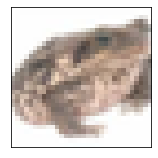

label: frog confidence: 0.99983466

After


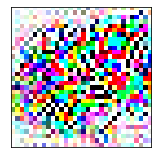

label: airplane confidence: 0.72216696

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

performance on adversarial examples:
 Accuracy: 0.07 
               precision    recall  f1-score   support

           0

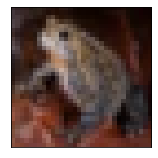

label: frog confidence: 0.9949463

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.07 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00

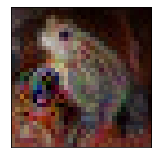

label: bird confidence: 0.52002704

With  label_smoothing defense applied

BEFORE DEFENSE


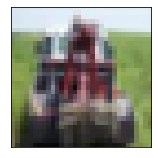

label: truck confidence: 0.5808423

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.07 
               precision    recall  f1-score   support

           0       0.00      0.00      0.0

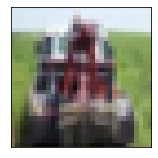

label: ship confidence: 0.5001795

With  class_labels defense applied

BEFORE DEFENSE


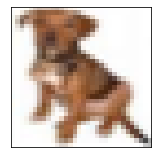

label: dog confidence: 0.99998534

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18  

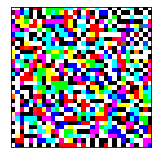

label: truck confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


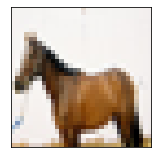

label: horse confidence: 0.9995067

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18 

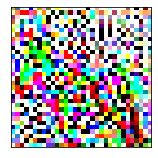

label: airplane confidence: 0.0

With  feature_squeezing defense applied

BEFORE DEFENSE


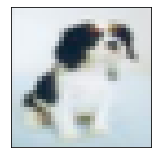

label: dog confidence: 0.99994314

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.07 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00

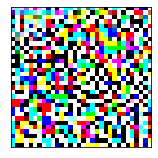

label: truck confidence: 0.97346085

With  spatial_smoothing defense applied

BEFORE DEFENSE


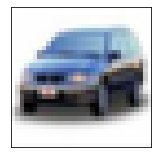

label: automobile confidence: 0.9999989

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.07 
               precision    recall  f1-score   support

           0       0.00      0.00    

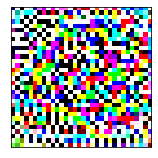

label: truck confidence: 0.97558695

With  thermometer_encoding defense applied

BEFORE DEFENSE


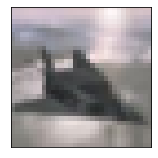

label: airplane confidence: 0.9882334

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.07 
               precision    recall  f1-score   support

           0       0.00      0.00      

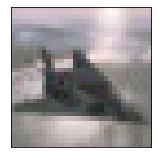

label: bird confidence: 0.453067

With  variance_minimization defense applied

BEFORE DEFENSE


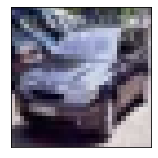

label: automobile confidence: 0.99983346

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.07 
               precision    recall  f1-score   support

           0       0.00      0.00   

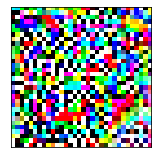

label: truck confidence: 0.9960102

With  reverse_sigmoid defense applied

BEFORE DEFENSE


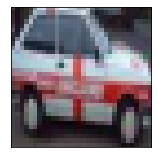

label: automobile confidence: 0.9600528

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.07 
               precision    recall  f1-score   support

           0       0.00      0.00    

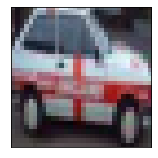

label: truck confidence: 0.32110822

With  rounded defense applied

BEFORE DEFENSE


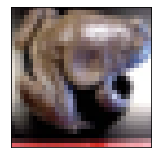

label: frog confidence: 0.98686534

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.03 
               precision    recall  f1-score   support

           0       0.00      0.00      0.0

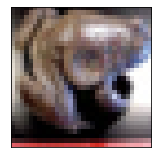

label: cat confidence: 0.99

With  adversarial_trainer_madry_pgd defense applied

BEFORE DEFENSE


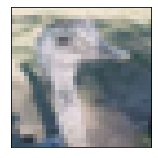

label: bird confidence: 0.99466187

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.07 
               precision    recall  f1-score   support

           0       0.00      0.00      0.0

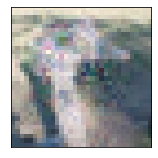

label: frog confidence: 0.9776718

With  evasion defense applied

BEFORE DEFENSE


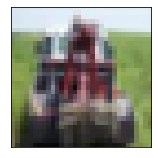

label: truck confidence: 0.5808423

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.07 
               precision    recall  f1-score   support

           0       0.00      0.00      0.0

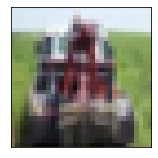

label: ship confidence: 0.5001795

With  0, std=1 defense applied

BEFORE DEFENSE


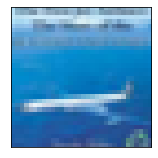

label: airplane confidence: 0.9935533

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.07 
               precision    recall  f1-score   support

           0       0.00      0.00      

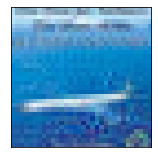

label: truck confidence: 0.61466825

With  0, std=1 defense applied

BEFORE DEFENSE


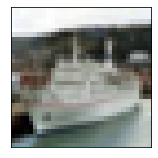

label: ship confidence: 0.9999701

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.07 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00

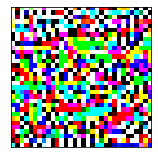

label: truck confidence: 0.7488237


In [ ]:
from art.attacks.evasion import DeepFool

deep_fool = DeepFool(classifier=classifier,batch_size=32,max_iter=5)

perform_attack(deep_fool, defenses)


Carlini & Wagner (C&W) L_2 and L_inf attack


C&W L_2:   0%|          | 0/4 [00:00<?, ?it/s]


Attack effects on image

Before


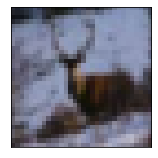

label: deer confidence: 0.9989409

After


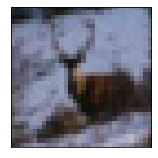

label: bird confidence: 0.8809512

Before


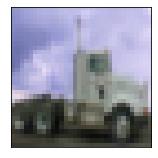

label: truck confidence: 0.998872

After


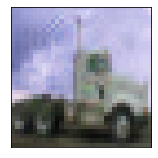

label: bird confidence: 0.6901268

Before


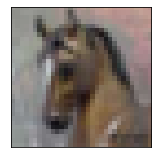

label: horse confidence: 0.99986064

After


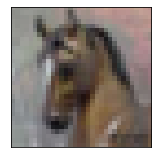

label: cat confidence: 0.9988827

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

performance on adversarial examples:
 Accuracy: 0.19 
               precision    recall  f1-score   support

           0      

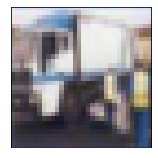

label: truck confidence: 0.9998945

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.19 
               precision    recall  f1-score   support

           0       0.23      0.30      0.2

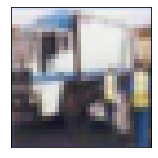

label: ship confidence: 0.94399905

With  label_smoothing defense applied

BEFORE DEFENSE


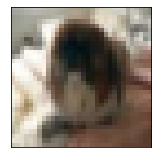

label: dog confidence: 0.99083734

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.19 
               precision    recall  f1-score   support

           0       0.23      0.30      0.26

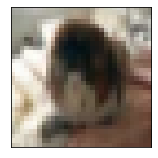

label: cat confidence: 0.6934259

With  class_labels defense applied

BEFORE DEFENSE


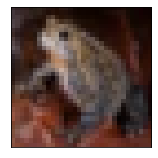

label: frog confidence: 0.9949463

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18  

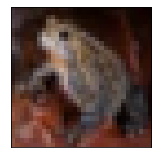

label: dog confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


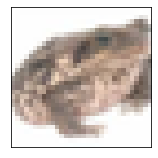

label: frog confidence: 0.99983466

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18 

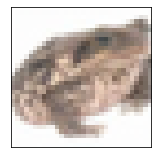

label: airplane confidence: 0.0

With  feature_squeezing defense applied

BEFORE DEFENSE


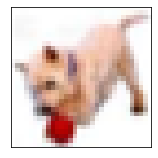

label: dog confidence: 0.9842609

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.19 
               precision    recall  f1-score   support

           0       0.23      0.30      0.26 

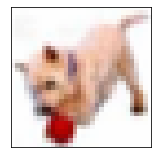

label: cat confidence: 0.59588426

With  spatial_smoothing defense applied

BEFORE DEFENSE


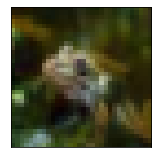

label: frog confidence: 0.9997274

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.19 
               precision    recall  f1-score   support

           0       0.23      0.30      0.26

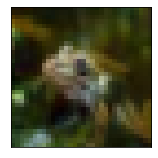

label: bird confidence: 0.55869573

With  thermometer_encoding defense applied

BEFORE DEFENSE


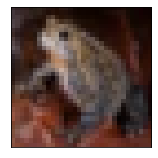

label: frog confidence: 0.9949463

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.19 
               precision    recall  f1-score   support

           0       0.23      0.30      0.26

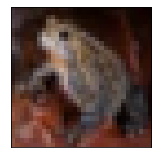

label: dog confidence: 0.8523416

With  variance_minimization defense applied

BEFORE DEFENSE


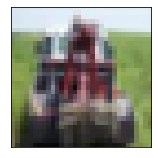

label: truck confidence: 0.5808423

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.19 
               precision    recall  f1-score   support

           0       0.23      0.30      0.2

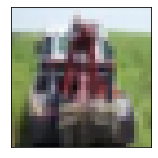

label: ship confidence: 0.49983066

With  reverse_sigmoid defense applied

BEFORE DEFENSE


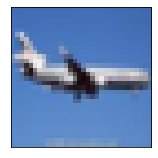

label: airplane confidence: 0.99994016

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.19 
               precision    recall  f1-score   support

           0       0.23      0.30     

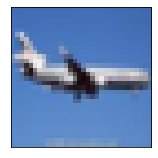

label: airplane confidence: 0.2355274

With  rounded defense applied

BEFORE DEFENSE


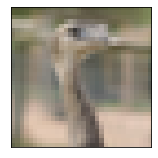

label: bird confidence: 0.9999256

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.21 
               precision    recall  f1-score   support

           0       0.29      0.40      0.33

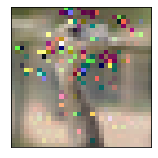

label: airplane confidence: 0.99

With  adversarial_trainer_madry_pgd defense applied

BEFORE DEFENSE


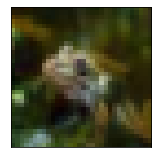

label: frog confidence: 0.9997274

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.19 
               precision    recall  f1-score   support

           0       0.23      0.30      0.26

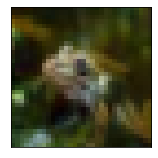

label: bird confidence: 0.55869573

With  evasion defense applied

BEFORE DEFENSE


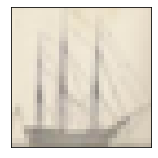

label: ship confidence: 0.99897397

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.19 
               precision    recall  f1-score   support

           0       0.23      0.30      0.2

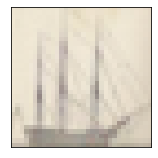

label: deer confidence: 0.997274

With  0, std=1 defense applied

BEFORE DEFENSE


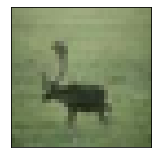

label: deer confidence: 0.9893441

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.19 
               precision    recall  f1-score   support

           0       0.23      0.30      0.26

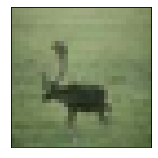

label: bird confidence: 0.5457119

With  0, std=1 defense applied

BEFORE DEFENSE


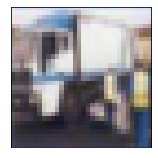

label: truck confidence: 0.9998945

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.19 
               precision    recall  f1-score   support

           0       0.23      0.30      0.2

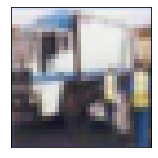

label: ship confidence: 0.94399905
                                                 TARGETED ATTACK                                                


C&W L_2:   0%|          | 0/4 [00:00<?, ?it/s]


Attack effects on image

Before


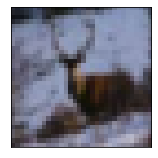

label: deer confidence: 0.9989409

After


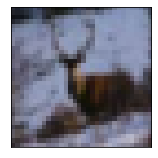

label: deer confidence: 0.9989409

Before


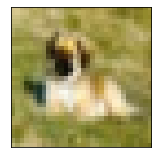

label: dog confidence: 0.9999889

After


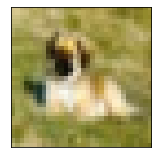

label: dog confidence: 0.9999889

Before


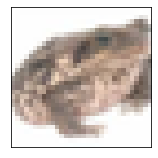

label: frog confidence: 0.99983466

After


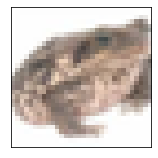

label: frog confidence: 0.99983466

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0     

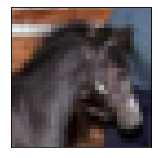

label: horse confidence: 0.995503

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00 

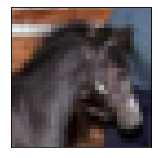

label: horse confidence: 0.995503

With  label_smoothing defense applied

BEFORE DEFENSE


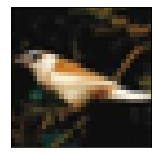

label: bird confidence: 0.99927574

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00

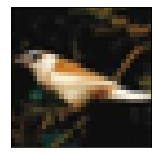

label: bird confidence: 0.99927574

With  class_labels defense applied

BEFORE DEFENSE


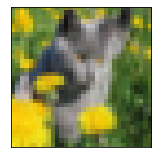

label: bird confidence: 0.6364619

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18  

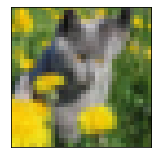

label: cat confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


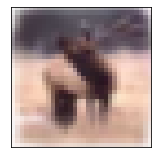

label: deer confidence: 0.99851316

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18 

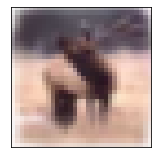

label: airplane confidence: 0.0

With  feature_squeezing defense applied

BEFORE DEFENSE


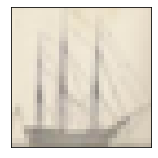

label: ship confidence: 0.99897397

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00

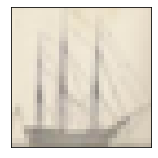

label: ship confidence: 0.99897397

With  spatial_smoothing defense applied

BEFORE DEFENSE


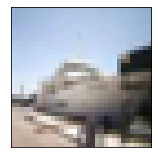

label: airplane confidence: 0.7270753

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1

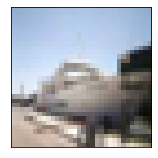

label: ship confidence: 0.49573258

With  thermometer_encoding defense applied

BEFORE DEFENSE


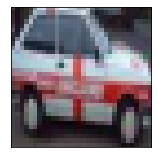

label: automobile confidence: 0.9600528

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00     

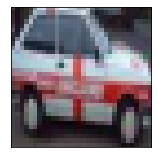

label: automobile confidence: 0.9600528

With  variance_minimization defense applied

BEFORE DEFENSE


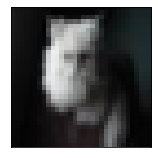

label: cat confidence: 0.9687347

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00  

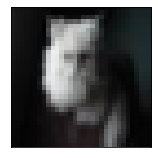

label: cat confidence: 0.9687347

With  reverse_sigmoid defense applied

BEFORE DEFENSE


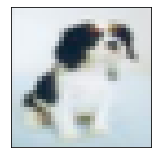

label: dog confidence: 0.99994314

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00 

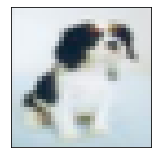

label: dog confidence: 0.2278209

With  rounded defense applied

BEFORE DEFENSE


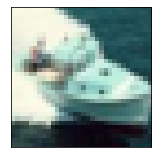

label: ship confidence: 0.999892

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.96 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95 

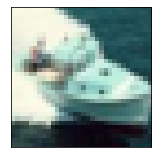

label: ship confidence: 1.0

With  adversarial_trainer_madry_pgd defense applied

BEFORE DEFENSE


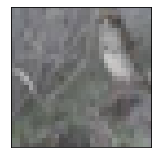

label: bird confidence: 0.98954624

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00

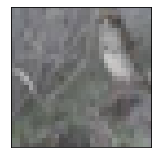

label: bird confidence: 0.98954624

With  evasion defense applied

BEFORE DEFENSE


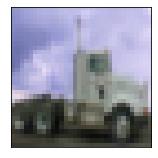

label: truck confidence: 0.998872

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00 

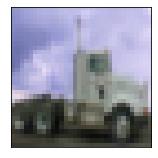

label: truck confidence: 0.998872

With  0, std=1 defense applied

BEFORE DEFENSE


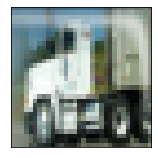

label: truck confidence: 0.99994314

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.0

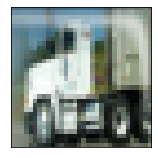

label: truck confidence: 0.99994314

With  0, std=1 defense applied

BEFORE DEFENSE


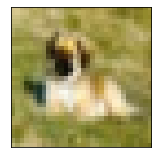

label: dog confidence: 0.9999889

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00  

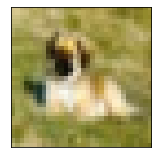

label: dog confidence: 0.9999889


In [ ]:
from art.attacks.evasion import CarliniL2Method
carlini_l2 = CarliniL2Method(classifier=classifier,batch_size=32)
carlini_l2_targeted = CarliniL2Method(classifier=classifier,batch_size=32,targeted=True)
perform_attack(carlini_l2, defenses)
print('                                                 TARGETED ATTACK                                                ')
perform_attack(carlini_l2_targeted, defenses)

C&W L_inf:   0%|          | 0/2 [00:00<?, ?it/s]


Attack effects on image

Before


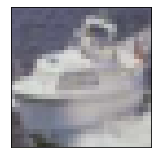

label: ship confidence: 0.99994326

After


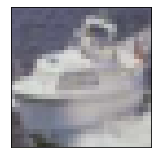

label: ship confidence: 0.99994326

Before


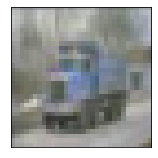

label: truck confidence: 0.99986684

After


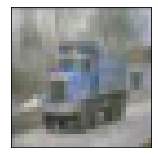

label: ship confidence: 0.88919085

Before


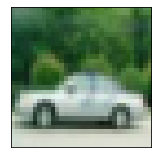

label: automobile confidence: 0.9998956

After


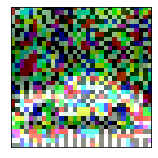

label: bird confidence: 0.4009146

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

performance on adversarial examples:
 Accuracy: 0.21 
               precision    recall  f1-score   support

           0     

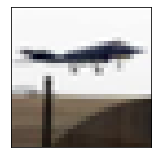

label: airplane confidence: 0.9974567

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.21 
               precision    recall  f1-score   support

           0       0.21      0.30      

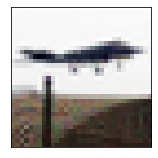

label: ship confidence: 0.53868586

With  label_smoothing defense applied

BEFORE DEFENSE


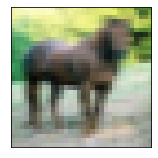

label: horse confidence: 0.98557013

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.21 
               precision    recall  f1-score   support

           0       0.21      0.30      0.

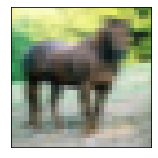

label: deer confidence: 0.75958467

With  class_labels defense applied

BEFORE DEFENSE


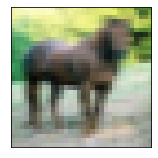

label: horse confidence: 0.98557013

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18

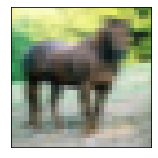

label: deer confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


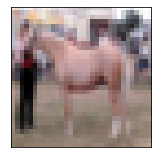

label: horse confidence: 0.99932027

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18

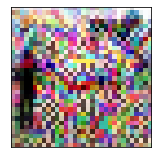

label: airplane confidence: 0.0

With  feature_squeezing defense applied

BEFORE DEFENSE


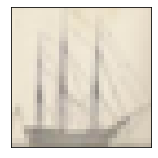

label: ship confidence: 0.99897397

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.21 
               precision    recall  f1-score   support

           0       0.21      0.30      0.2

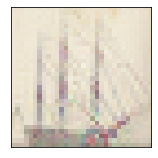

label: deer confidence: 0.9937902

With  spatial_smoothing defense applied

BEFORE DEFENSE


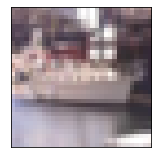

label: ship confidence: 0.9374856

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.21 
               precision    recall  f1-score   support

           0       0.21      0.30      0.25

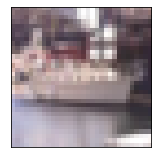

label: truck confidence: 0.53411704

With  thermometer_encoding defense applied

BEFORE DEFENSE


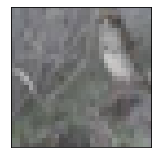

label: bird confidence: 0.98954624

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.21 
               precision    recall  f1-score   support

           0       0.21      0.30      0.2

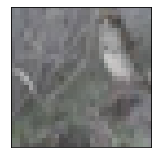

label: airplane confidence: 0.5337748

With  variance_minimization defense applied

BEFORE DEFENSE


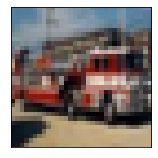

label: truck confidence: 0.9999064

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.21 
               precision    recall  f1-score   support

           0       0.21      0.30      0.2

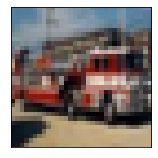

label: truck confidence: 0.9999064

With  reverse_sigmoid defense applied

BEFORE DEFENSE


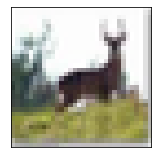

label: deer confidence: 0.99752337

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.21 
               precision    recall  f1-score   support

           0       0.21      0.30      0.2

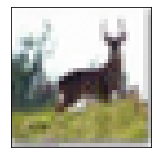

label: dog confidence: 0.3527132

With  rounded defense applied

BEFORE DEFENSE


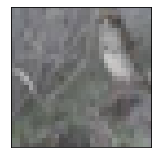

label: bird confidence: 0.98954624

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.21 
               precision    recall  f1-score   support

           0       0.21      0.30      0.2

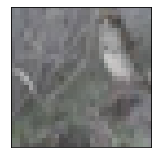

label: airplane confidence: 0.53

With  adversarial_trainer_madry_pgd defense applied

BEFORE DEFENSE


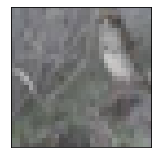

label: bird confidence: 0.98954624

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.21 
               precision    recall  f1-score   support

           0       0.21      0.30      0.2

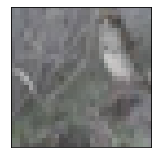

label: airplane confidence: 0.5337748

With  evasion defense applied

BEFORE DEFENSE


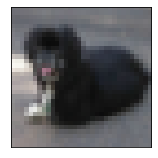

label: dog confidence: 0.9984774

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.21 
               precision    recall  f1-score   support

           0       0.21      0.30      0.25 

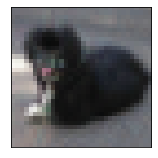

label: cat confidence: 0.99896395

With  0, std=1 defense applied

BEFORE DEFENSE


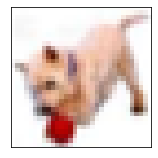

label: dog confidence: 0.9842609

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.21 
               precision    recall  f1-score   support

           0       0.21      0.30      0.25 

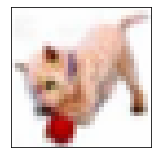

label: cat confidence: 0.999835

With  0, std=1 defense applied

BEFORE DEFENSE


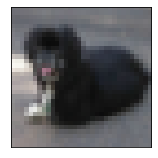

label: dog confidence: 0.9984774

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.21 
               precision    recall  f1-score   support

           0       0.21      0.30      0.25 

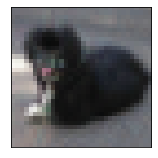

label: cat confidence: 0.99896395
                                                 TARGETED ATTACK                                                


C&W L_inf:   0%|          | 0/2 [00:00<?, ?it/s]


Attack effects on image

Before


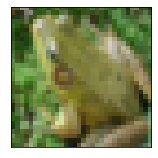

label: frog confidence: 0.9998198

After


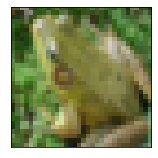

label: frog confidence: 0.9998198

Before


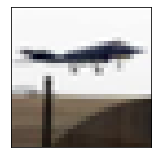

label: airplane confidence: 0.9974567

After


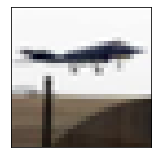

label: airplane confidence: 0.9974567

Before


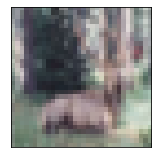

label: deer confidence: 0.98033464

After


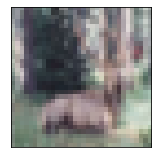

label: deer confidence: 0.98033464

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0     

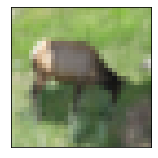

label: deer confidence: 0.9998647

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00 

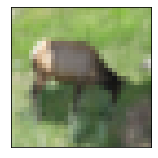

label: deer confidence: 0.9998647

With  label_smoothing defense applied

BEFORE DEFENSE


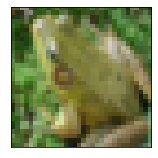

label: frog confidence: 0.9998198

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00 

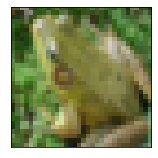

label: frog confidence: 0.9998198

With  class_labels defense applied

BEFORE DEFENSE


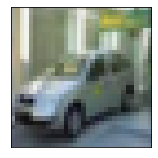

label: automobile confidence: 0.99938846

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00     

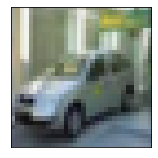

label: automobile confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


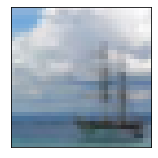

label: ship confidence: 0.99998903

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18 

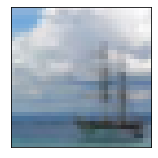

label: airplane confidence: 0.0

With  feature_squeezing defense applied

BEFORE DEFENSE


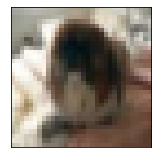

label: dog confidence: 0.99083734

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00 

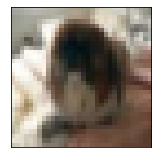

label: dog confidence: 0.99083734

With  spatial_smoothing defense applied

BEFORE DEFENSE


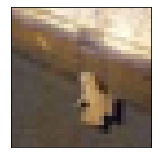

label: airplane confidence: 0.76719046

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      

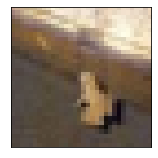

label: frog confidence: 0.36362898

With  thermometer_encoding defense applied

BEFORE DEFENSE


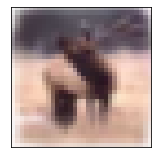

label: deer confidence: 0.99851316

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00

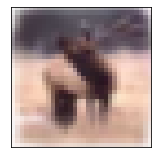

label: deer confidence: 0.99851316

With  variance_minimization defense applied

BEFORE DEFENSE


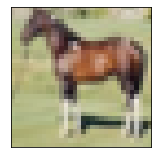

label: horse confidence: 0.99915445

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.0

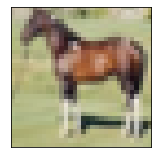

label: horse confidence: 0.99915445

With  reverse_sigmoid defense applied

BEFORE DEFENSE


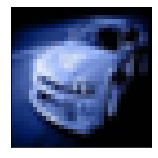

label: automobile confidence: 0.9959013

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00     

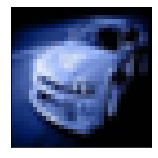

label: automobile confidence: 0.26347947

With  rounded defense applied

BEFORE DEFENSE


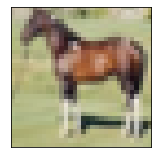

label: horse confidence: 0.99915445

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.0

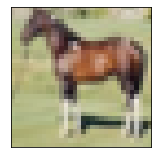

label: horse confidence: 1.0

With  adversarial_trainer_madry_pgd defense applied

BEFORE DEFENSE


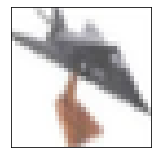

label: airplane confidence: 0.99961156

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      

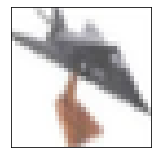

label: airplane confidence: 0.99961156

With  evasion defense applied

BEFORE DEFENSE


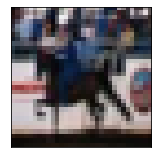

label: horse confidence: 0.99496764

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.0

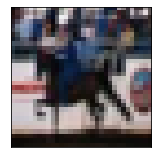

label: horse confidence: 0.99496764

With  0, std=1 defense applied

BEFORE DEFENSE


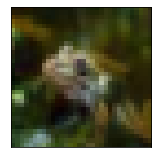

label: frog confidence: 0.9997274

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00 

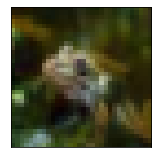

label: frog confidence: 0.9997274

With  0, std=1 defense applied

BEFORE DEFENSE


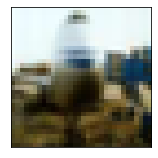

label: airplane confidence: 0.98980546

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      

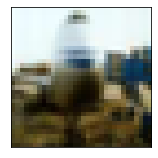

label: airplane confidence: 0.98980546


In [ ]:
from art.attacks.evasion import CarliniLInfMethod

carlini_linf = CarliniLInfMethod(classifier=classifier,batch_size=50)
carlini_linf_targeted = CarliniLInfMethod(classifier=classifier,batch_size=50,targeted=True)


perform_attack(carlini_linf, defenses)
print('                                                 TARGETED ATTACK                                                ')
perform_attack(carlini_linf_targeted, defenses)

Project Gradient Attack


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]


Attack effects on image

Before


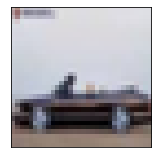

label: automobile confidence: 0.90567017

After


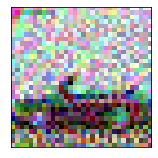

label: frog confidence: 0.99999535

Before


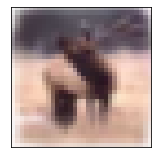

label: deer confidence: 0.99851316

After


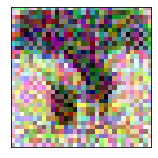

label: bird confidence: 1.0

Before


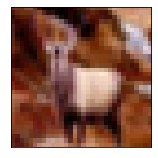

label: deer confidence: 0.86077994

After


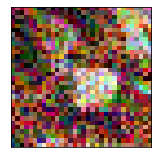

label: frog confidence: 0.9999999

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0      

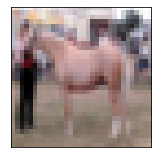

label: horse confidence: 0.99932027

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.0

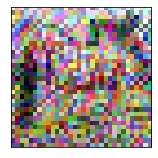

label: bird confidence: 0.99994767

With  label_smoothing defense applied

BEFORE DEFENSE


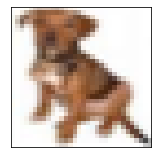

label: dog confidence: 0.99998534

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00 

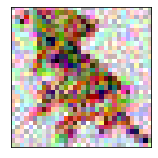

label: frog confidence: 0.9999925

With  class_labels defense applied

BEFORE DEFENSE


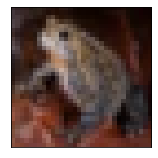

label: frog confidence: 0.9949463

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00  

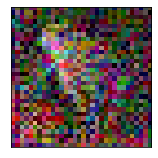

label: cat confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


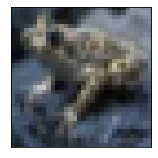

label: frog confidence: 0.9991872

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.08 
               precision    recall  f1-score   support

           0       0.12      0.80      0.22 

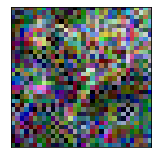

label: airplane confidence: 0.0

With  feature_squeezing defense applied

BEFORE DEFENSE


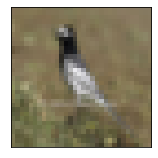

label: bird confidence: 0.9999212

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00 

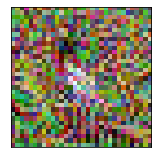

label: frog confidence: 0.9999988

With  spatial_smoothing defense applied

BEFORE DEFENSE


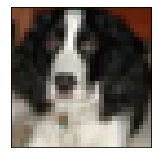

label: dog confidence: 0.99852633

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00 

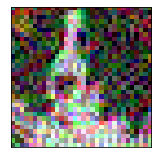

label: frog confidence: 1.0

With  thermometer_encoding defense applied

BEFORE DEFENSE


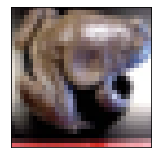

label: frog confidence: 0.98686534

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00

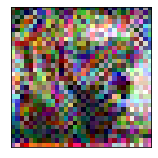

label: bird confidence: 0.99999976

With  variance_minimization defense applied

BEFORE DEFENSE


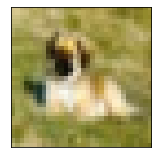

label: dog confidence: 0.9999889

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00  

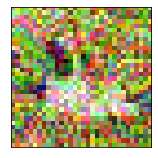

label: frog confidence: 1.0

With  reverse_sigmoid defense applied

BEFORE DEFENSE


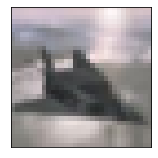

label: airplane confidence: 0.9882334

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0

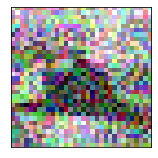

label: frog confidence: 0.18710089

With  rounded defense applied

BEFORE DEFENSE


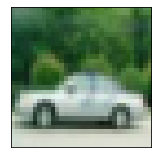

label: automobile confidence: 0.9998956

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00     

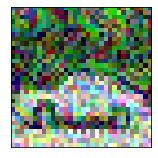

label: frog confidence: 1.0

With  adversarial_trainer_madry_pgd defense applied

BEFORE DEFENSE


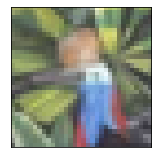

label: bird confidence: 0.99915814

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00

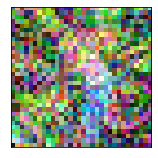

label: frog confidence: 1.0

With  evasion defense applied

BEFORE DEFENSE


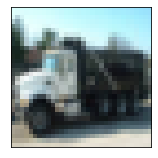

label: truck confidence: 0.99999475

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.0

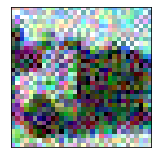

label: bird confidence: 0.9999999

With  0, std=1 defense applied

BEFORE DEFENSE


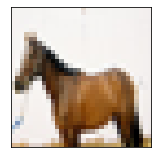

label: horse confidence: 0.9995067

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00

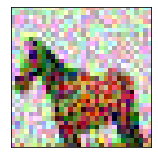

label: frog confidence: 0.99999714

With  0, std=1 defense applied

BEFORE DEFENSE


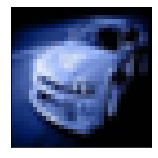

label: automobile confidence: 0.9959013

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00     

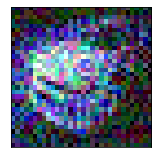

label: frog confidence: 1.0

                                                 TARGETED ATTACK                                                



PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]


Attack effects on image

Before


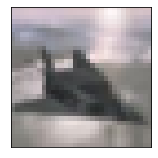

label: airplane confidence: 0.9882334

After


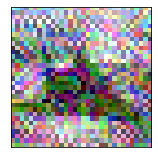

label: airplane confidence: 1.0

Before


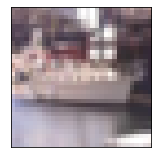

label: ship confidence: 0.9374856

After


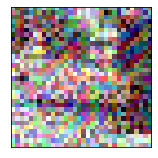

label: ship confidence: 0.99999595

Before


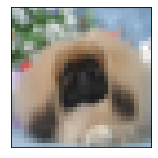

label: dog confidence: 0.9993801

After


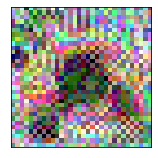

label: dog confidence: 1.0

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00 

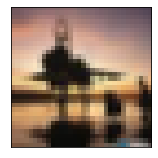

label: airplane confidence: 0.9863798

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00      

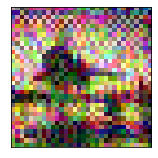

label: airplane confidence: 1.0

With  label_smoothing defense applied

BEFORE DEFENSE


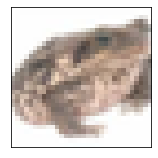

label: frog confidence: 0.99983466

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00      1.0

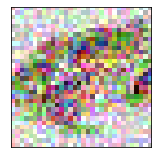

label: frog confidence: 1.0

With  class_labels defense applied

BEFORE DEFENSE


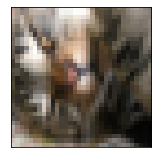

label: cat confidence: 0.62254846

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18  

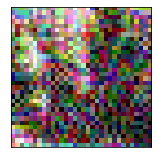

label: cat confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


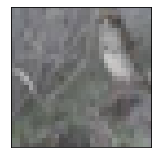

label: bird confidence: 0.98954624

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.59 
               precision    recall  f1-score   support

           0       0.20      1.00      0.33

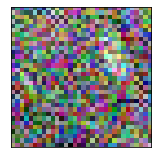

label: airplane confidence: 0.0

With  feature_squeezing defense applied

BEFORE DEFENSE


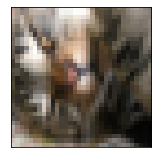

label: cat confidence: 0.62254846

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00

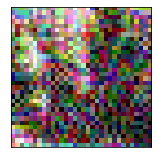

label: cat confidence: 1.0

With  spatial_smoothing defense applied

BEFORE DEFENSE


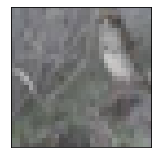

label: bird confidence: 0.98954624

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00      1.0

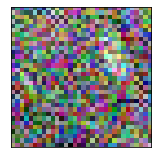

label: bird confidence: 0.99999964

With  thermometer_encoding defense applied

BEFORE DEFENSE


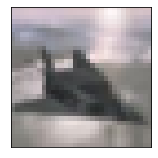

label: airplane confidence: 0.9882334

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00      

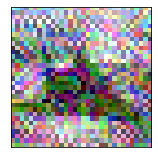

label: airplane confidence: 1.0

With  variance_minimization defense applied

BEFORE DEFENSE


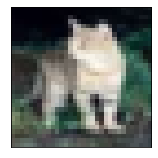

label: cat confidence: 0.9997733

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00 

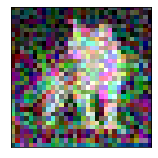

label: cat confidence: 0.99999964

With  reverse_sigmoid defense applied

BEFORE DEFENSE


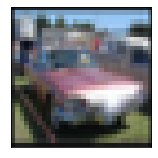

label: automobile confidence: 0.99996984

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00   

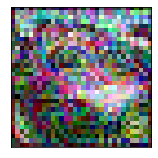

label: automobile confidence: 0.17438833

With  rounded defense applied

BEFORE DEFENSE


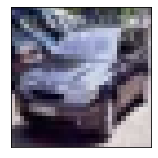

label: automobile confidence: 0.99983346

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00   

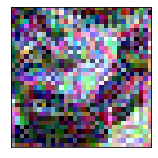

label: automobile confidence: 1.0

With  adversarial_trainer_madry_pgd defense applied

BEFORE DEFENSE


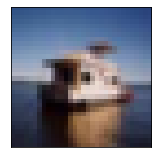

label: ship confidence: 0.9676307

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00

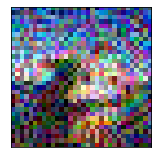

label: ship confidence: 0.9999989

With  evasion defense applied

BEFORE DEFENSE


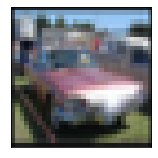

label: automobile confidence: 0.99996984

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00   

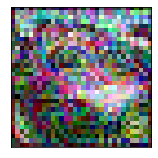

label: automobile confidence: 0.9999994

With  0, std=1 defense applied

BEFORE DEFENSE


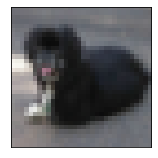

label: dog confidence: 0.9984774

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00 

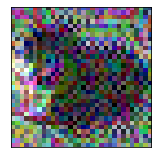

label: dog confidence: 1.0

With  0, std=1 defense applied

BEFORE DEFENSE


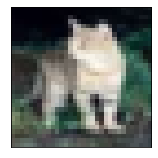

label: cat confidence: 0.9997733

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.99 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00 

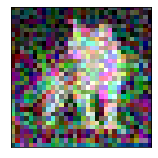

label: cat confidence: 0.99999964


In [ ]:
from art.attacks.evasion import ProjectedGradientDescent

projected_gradient_descent = ProjectedGradientDescent(estimator=classifier,batch_size=32)
projected_gradient_descent_targeted = ProjectedGradientDescent(estimator=classifier,batch_size=32,targeted=True)

perform_attack(projected_gradient_descent, defenses)
print('                                                 TARGETED ATTACK                                                ')
perform_attack(projected_gradient_descent_targeted, defenses)

Jacobian Saliency Map Method

JSMA:   0%|          | 0/100 [00:00<?, ?it/s]


Attack effects on image

Before


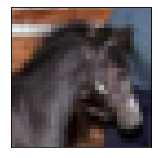

label: horse confidence: 0.995503

After


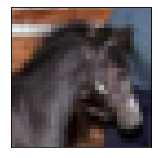

label: horse confidence: 0.995503

Before


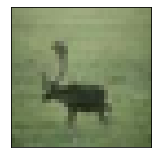

label: deer confidence: 0.9893441

After


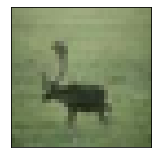

label: deer confidence: 0.9893441

Before


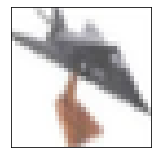

label: airplane confidence: 0.99961156

After


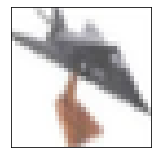

label: airplane confidence: 0.99961156

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0 

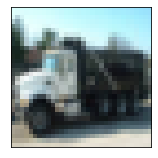

label: truck confidence: 0.99999475

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.0

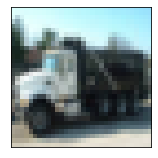

label: truck confidence: 0.99999475

With  label_smoothing defense applied

BEFORE DEFENSE


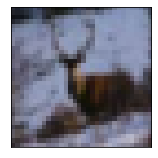

label: deer confidence: 0.9989409

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00 

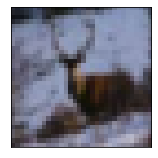

label: deer confidence: 0.9989409

With  class_labels defense applied

BEFORE DEFENSE


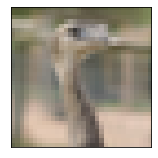

label: bird confidence: 0.9999256

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18  

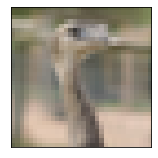

label: bird confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


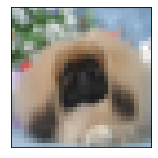

label: dog confidence: 0.9993801

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18   

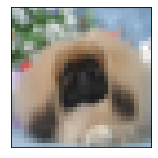

label: airplane confidence: 0.0

With  feature_squeezing defense applied

BEFORE DEFENSE


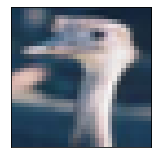

label: bird confidence: 0.99977463

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00

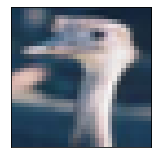

label: bird confidence: 0.99977463

With  spatial_smoothing defense applied

BEFORE DEFENSE


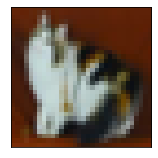

label: cat confidence: 0.99208164

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00 

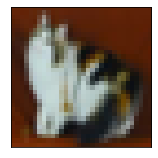

label: cat confidence: 0.99208164

With  thermometer_encoding defense applied

BEFORE DEFENSE


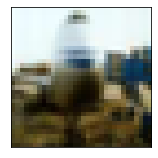

label: airplane confidence: 0.98980546

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      

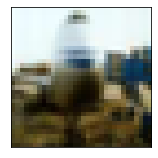

label: airplane confidence: 0.98980546

With  variance_minimization defense applied

BEFORE DEFENSE


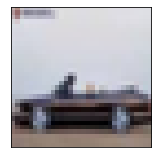

label: automobile confidence: 0.90567017

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00    

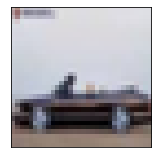

label: automobile confidence: 0.90567017

With  reverse_sigmoid defense applied

BEFORE DEFENSE


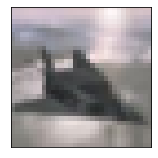

label: airplane confidence: 0.9882334

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1

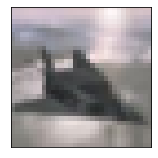

label: airplane confidence: 0.29810783

With  rounded defense applied

BEFORE DEFENSE


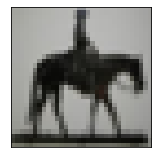

label: horse confidence: 0.9993476

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00

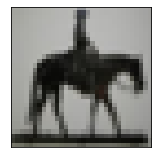

label: horse confidence: 1.0

With  adversarial_trainer_madry_pgd defense applied

BEFORE DEFENSE


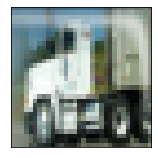

label: truck confidence: 0.99994314

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.0

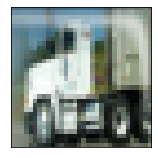

label: truck confidence: 0.99994314

With  evasion defense applied

BEFORE DEFENSE


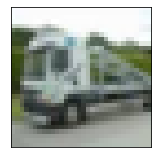

label: truck confidence: 0.9996532

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00

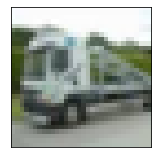

label: truck confidence: 0.9996532

With  0, std=1 defense applied

BEFORE DEFENSE


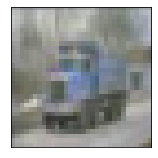

label: truck confidence: 0.99986684

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.0

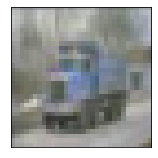

label: truck confidence: 0.99986684

With  0, std=1 defense applied

BEFORE DEFENSE


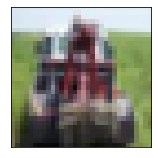

label: truck confidence: 0.5808423

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 1.0 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00

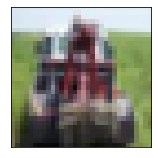

label: truck confidence: 0.5808423


In [ ]:
from art.attacks.evasion import SaliencyMapMethod
saliency_map = SaliencyMapMethod(classifier=classifier)
perform_attack(saliency_map, defenses)

Universal Pertubation Attack

Universal perturbation:   0%|          | 0/20 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]


Attack effects on image

Before


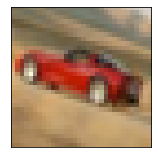

label: automobile confidence: 0.9999863

After


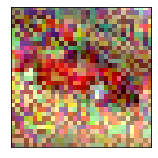

label: frog confidence: 0.38262707

Before


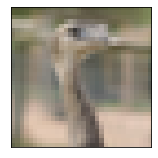

label: bird confidence: 0.9999256

After


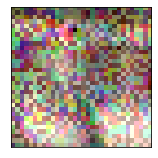

label: cat confidence: 0.5313627

Before


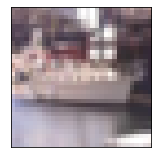

label: ship confidence: 0.9374856

After


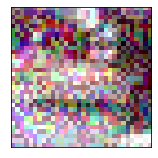

label: frog confidence: 0.99499315

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

performance on adversarial examples:
 Accuracy: 0.12 
               precision    recall  f1-score   support

           0    

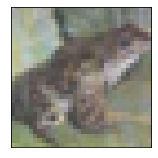

label: frog confidence: 0.99953103

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.12 
               precision    recall  f1-score   support

           0       0.33      0.20      0.2

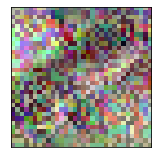

label: frog confidence: 0.6028359

With  label_smoothing defense applied

BEFORE DEFENSE


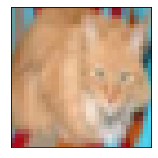

label: cat confidence: 0.9997204

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.12 
               precision    recall  f1-score   support

           0       0.33      0.20      0.25 

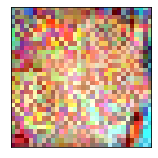

label: cat confidence: 0.41044497

With  class_labels defense applied

BEFORE DEFENSE


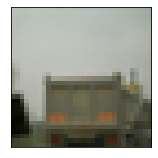

label: truck confidence: 0.7014935

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18 

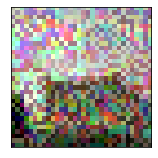

label: frog confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


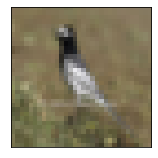

label: bird confidence: 0.9999212

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18  

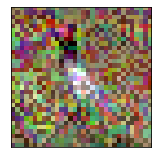

label: airplane confidence: 0.0

With  feature_squeezing defense applied

BEFORE DEFENSE


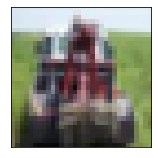

label: truck confidence: 0.5808423

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.12 
               precision    recall  f1-score   support

           0       0.33      0.20      0.2

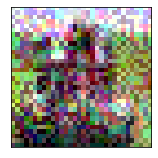

label: frog confidence: 0.86873025

With  spatial_smoothing defense applied

BEFORE DEFENSE


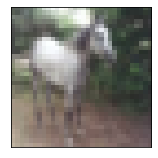

label: horse confidence: 0.99978405

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.12 
               precision    recall  f1-score   support

           0       0.33      0.20      0.

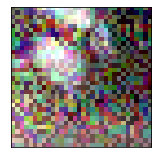

label: bird confidence: 0.60482967

With  thermometer_encoding defense applied

BEFORE DEFENSE


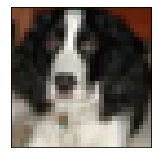

label: dog confidence: 0.99852633

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.12 
               precision    recall  f1-score   support

           0       0.33      0.20      0.25

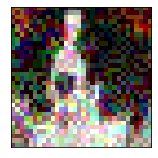

label: frog confidence: 0.5386752

With  variance_minimization defense applied

BEFORE DEFENSE


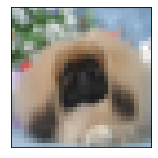

label: dog confidence: 0.9993801

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.12 
               precision    recall  f1-score   support

           0       0.33      0.20      0.25 

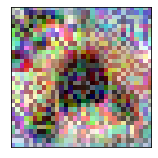

label: bird confidence: 0.8386282

With  reverse_sigmoid defense applied

BEFORE DEFENSE


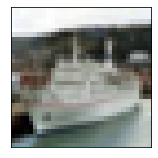

label: ship confidence: 0.9999701

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.12 
               precision    recall  f1-score   support

           0       0.33      0.20      0.25

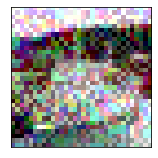

label: frog confidence: 0.3906301

With  rounded defense applied

BEFORE DEFENSE


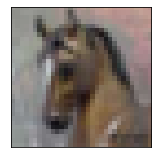

label: horse confidence: 0.99986064

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.12 
               precision    recall  f1-score   support

           0       0.33      0.20      0.

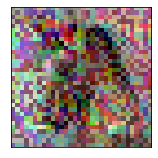

label: bird confidence: 0.53

With  adversarial_trainer_madry_pgd defense applied

BEFORE DEFENSE


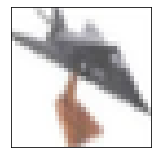

label: airplane confidence: 0.99961156

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.12 
               precision    recall  f1-score   support

           0       0.33      0.20     

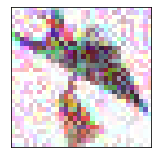

label: cat confidence: 0.7429131

With  evasion defense applied

BEFORE DEFENSE


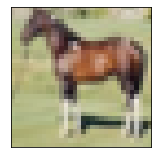

label: horse confidence: 0.99915445

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.12 
               precision    recall  f1-score   support

           0       0.33      0.20      0.

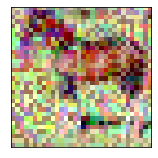

label: frog confidence: 0.9283949

With  0, std=1 defense applied

BEFORE DEFENSE


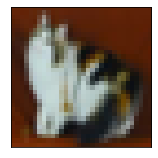

label: cat confidence: 0.99208164

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.12 
               precision    recall  f1-score   support

           0       0.33      0.20      0.25

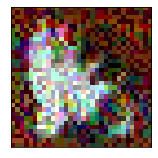

label: bird confidence: 0.7233622

With  0, std=1 defense applied

BEFORE DEFENSE


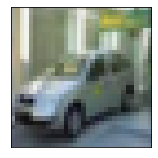

label: automobile confidence: 0.99938846

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.12 
               precision    recall  f1-score   support

           0       0.33      0.20   

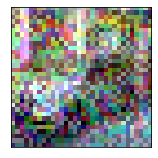

label: bird confidence: 0.8318113


In [ ]:
from art.attacks.evasion import UniversalPerturbation

universal_perturbation = UniversalPerturbation(classifier=classifier)

perform_attack(universal_perturbation, defenses)

Auto attack

In [ ]:
from numpy import inf
from art.attacks.evasion import ShadowAttack
auto_attack = ShadowAttack(estimator=classifier,eps = 0.3, eps_step = 0.1, max_iter = 100, targeted = False, batch_size = 32, loss_type = None, verbose = True)
perform_attack(auto_attack, defenses)

TypeError: ignored

Virtual Adversarial Attack

In [ ]:
from art.attacks.evasion import VirtualAdversarialMethod

VirtualA = VirtualAdversarialMethod(classifier=classifier)

perform_attack(VirtualA, defenses)

VAT:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

**Black box attacks
**

Zoo Attack

ZOO:   0%|          | 0/100 [00:00<?, ?it/s]


Attack effects on image

Before


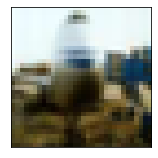

label: airplane confidence: 0.98980546

After


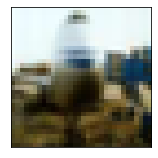

label: airplane confidence: 0.98980546

Before


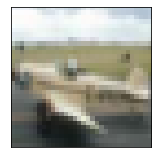

label: airplane confidence: 0.7294939

After


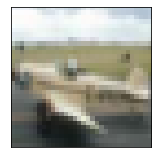

label: airplane confidence: 0.7294939

Before


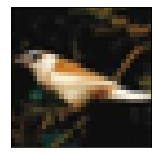

label: bird confidence: 0.99927574

After


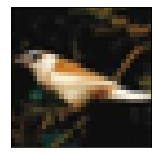

label: bird confidence: 0.99927574

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

performance on adversarial examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0    

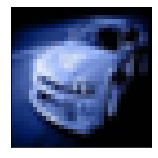

label: automobile confidence: 0.9959013

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       0.83      1.00    

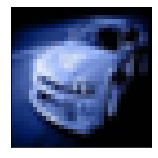

label: automobile confidence: 0.9959013

With  label_smoothing defense applied

BEFORE DEFENSE


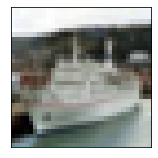

label: ship confidence: 0.9999701

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91

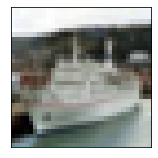

label: ship confidence: 0.9999701

With  class_labels defense applied

BEFORE DEFENSE


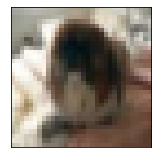

label: dog confidence: 0.99083734

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18  

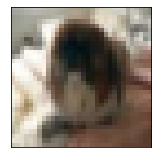

label: dog confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


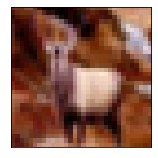

label: deer confidence: 0.86077994

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18 

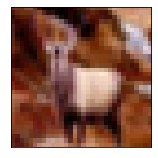

label: airplane confidence: 0.0

With  feature_squeezing defense applied

BEFORE DEFENSE


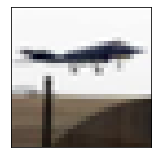

label: airplane confidence: 0.9974567

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       0.83      1.00      

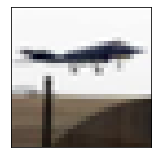

label: airplane confidence: 0.9974567

With  spatial_smoothing defense applied

BEFORE DEFENSE


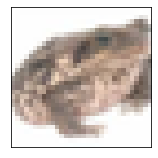

label: frog confidence: 0.99983466

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       0.83      1.00      0.9

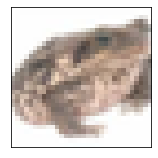

label: frog confidence: 0.99983466

With  thermometer_encoding defense applied

BEFORE DEFENSE


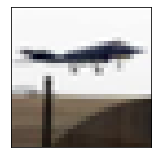

label: airplane confidence: 0.9974567

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       0.83      1.00      

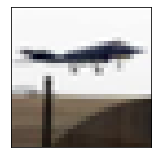

label: airplane confidence: 0.9974567

With  variance_minimization defense applied

BEFORE DEFENSE


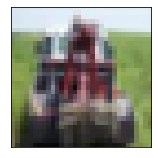

label: truck confidence: 0.5808423

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       0.83      1.00      0.9

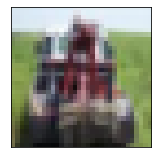

label: ship confidence: 0.58834547

With  reverse_sigmoid defense applied

BEFORE DEFENSE


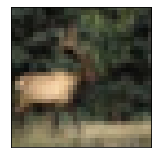

label: deer confidence: 0.99808913

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       0.83      1.00      0.9

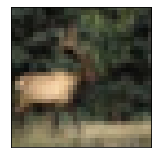

label: deer confidence: 0.27795586

With  rounded defense applied

BEFORE DEFENSE


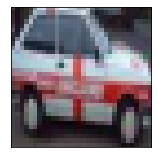

label: automobile confidence: 0.9600528

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       0.83      1.00    

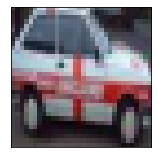

label: automobile confidence: 0.96

With  adversarial_trainer_madry_pgd defense applied

BEFORE DEFENSE


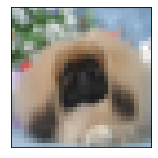

label: dog confidence: 0.9993801

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91 

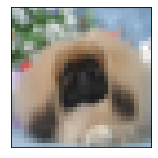

label: dog confidence: 0.9993801

With  evasion defense applied

BEFORE DEFENSE


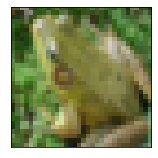

label: frog confidence: 0.9998198

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91

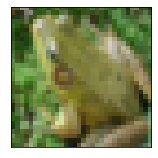

label: frog confidence: 0.9998198

With  0, std=1 defense applied

BEFORE DEFENSE


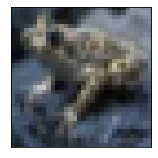

label: frog confidence: 0.9991872

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91

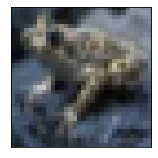

label: frog confidence: 0.9991872

With  0, std=1 defense applied

BEFORE DEFENSE


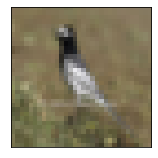

label: bird confidence: 0.9999212

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.92 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91

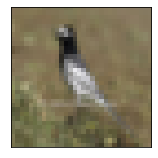

label: bird confidence: 0.9999212
                                                 TARGETED ATTACK                                                


ZOO:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
from art.attacks.evasion import ZooAttack
zoo_attack = ZooAttack(classifier=classifier, max_iter = 1, binary_search_steps=5)
zoo_attack_targeted = ZooAttack(classifier=classifier, max_iter = 1, binary_search_steps=5,targeted=True)
perform_attack(zoo_attack, defenses)
print('                                                 TARGETED ATTACK                                                ')
perform_attack(zoo_attack_targeted, defenses)

Hop skip jump attack

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]


Attack effects on image

Before


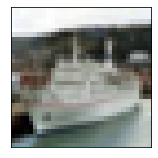

label: ship confidence: 0.9999701

After


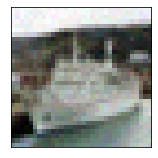

label: frog confidence: 0.9982749

Before


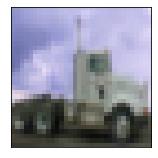

label: truck confidence: 0.998872

After


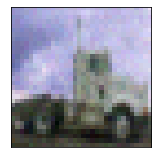

label: frog confidence: 0.9842367

Before


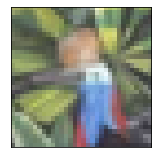

label: bird confidence: 0.99915814

After


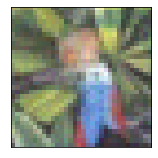

label: frog confidence: 0.9962256

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

performance on adversarial examples:
 Accuracy: 0.05 
               precision    recall  f1-score   support

           0     

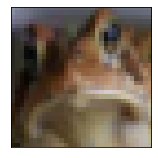

label: frog confidence: 0.9818379

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.05 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00

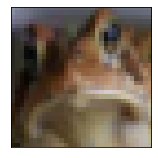

label: frog confidence: 0.9818379

With  label_smoothing defense applied

BEFORE DEFENSE


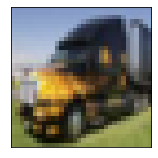

label: truck confidence: 0.9995741

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.05 
               precision    recall  f1-score   support

           0       0.00      0.00      0.0

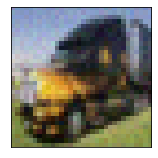

label: frog confidence: 0.99357855

With  class_labels defense applied

BEFORE DEFENSE


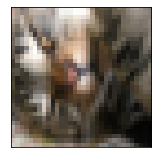

label: cat confidence: 0.62254846

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18  

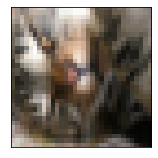

label: deer confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


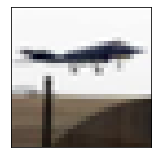

label: airplane confidence: 0.9974567

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.

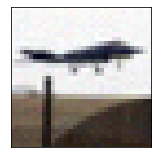

label: airplane confidence: 0.0

With  feature_squeezing defense applied

BEFORE DEFENSE


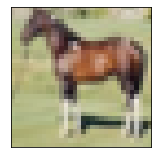

label: horse confidence: 0.99915445

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.05 
               precision    recall  f1-score   support

           0       0.00      0.00      0.

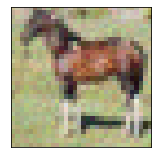

label: deer confidence: 0.99541336

With  spatial_smoothing defense applied

BEFORE DEFENSE


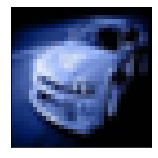

label: automobile confidence: 0.9959013

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.05 
               precision    recall  f1-score   support

           0       0.00      0.00    

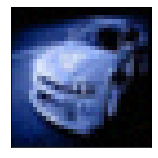

label: ship confidence: 0.91672844

With  thermometer_encoding defense applied

BEFORE DEFENSE


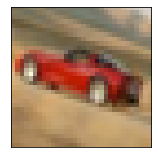

label: automobile confidence: 0.9999863

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.05 
               precision    recall  f1-score   support

           0       0.00      0.00    

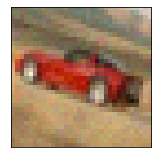

label: truck confidence: 0.99890196

With  variance_minimization defense applied

BEFORE DEFENSE


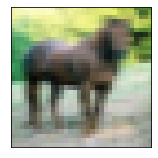

label: horse confidence: 0.98557013

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.05 
               precision    recall  f1-score   support

           0       0.00      0.00      0.

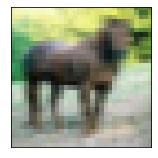

label: deer confidence: 0.90705866

With  reverse_sigmoid defense applied

BEFORE DEFENSE


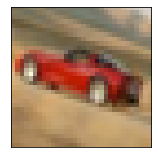

label: automobile confidence: 0.9999863

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.05 
               precision    recall  f1-score   support

           0       0.00      0.00    

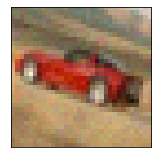

label: truck confidence: 0.2583058

With  rounded defense applied

BEFORE DEFENSE


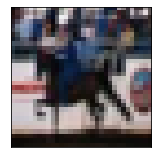

label: horse confidence: 0.99496764

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.05 
               precision    recall  f1-score   support

           0       0.00      0.00      0.

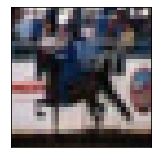

label: truck confidence: 0.92

With  adversarial_trainer_madry_pgd defense applied

BEFORE DEFENSE


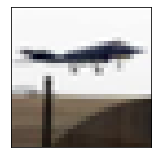

label: airplane confidence: 0.9974567

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.05 
               precision    recall  f1-score   support

           0       0.00      0.00      

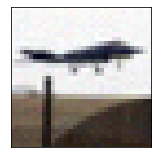

label: bird confidence: 0.9509304

With  evasion defense applied

BEFORE DEFENSE


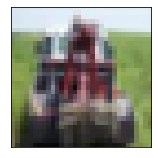

label: truck confidence: 0.5808423

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.05 
               precision    recall  f1-score   support

           0       0.00      0.00      0.0

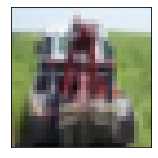

label: ship confidence: 0.5296511

With  0, std=1 defense applied

BEFORE DEFENSE


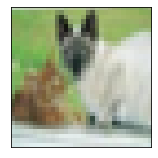

label: cat confidence: 0.9339586

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.05 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00 

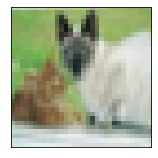

label: dog confidence: 0.7390478

With  0, std=1 defense applied

BEFORE DEFENSE


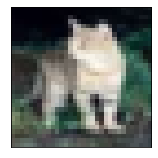

label: cat confidence: 0.9997733

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.05 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00 

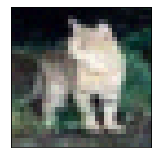

label: frog confidence: 0.96739435

                                                 TARGETED ATTACK                                                



HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]


Attack effects on image

Before


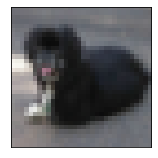

label: dog confidence: 0.9984774

After


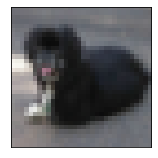

label: dog confidence: 0.9984774

Before


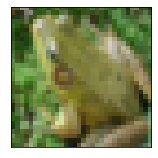

label: frog confidence: 0.9998198

After


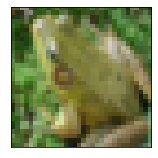

label: frog confidence: 0.9998198

Before


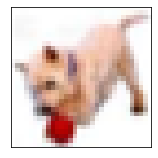

label: dog confidence: 0.9842609

After


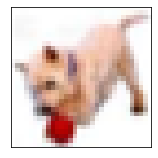

label: dog confidence: 0.9842609

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

performance on adversarial examples:
 Accuracy: 0.97 
               precision    recall  f1-score   support

           0      

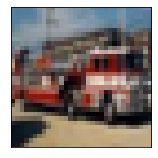

label: truck confidence: 0.9999064

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.97 
               precision    recall  f1-score   support

           0       0.91      1.00      0.9

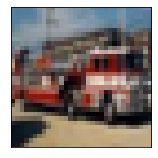

label: truck confidence: 0.9999064

With  label_smoothing defense applied

BEFORE DEFENSE


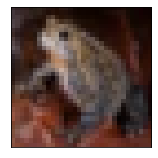

label: frog confidence: 0.9949463

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.97 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95

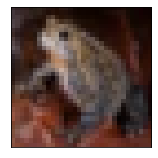

label: frog confidence: 0.9949463

With  class_labels defense applied

BEFORE DEFENSE


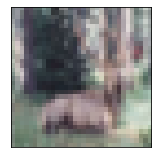

label: deer confidence: 0.98033464

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18 

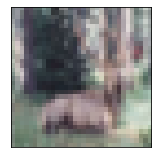

label: deer confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


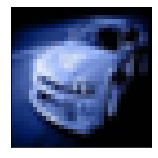

label: automobile confidence: 0.9959013

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      

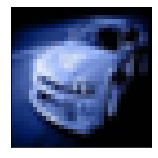

label: airplane confidence: 0.0

With  feature_squeezing defense applied

BEFORE DEFENSE


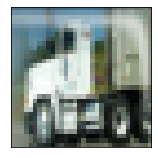

label: truck confidence: 0.99994314

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.97 
               precision    recall  f1-score   support

           0       0.91      1.00      0.

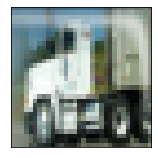

label: truck confidence: 0.99994314

With  spatial_smoothing defense applied

BEFORE DEFENSE


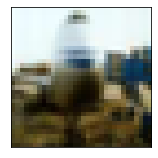

label: airplane confidence: 0.98980546

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.97 
               precision    recall  f1-score   support

           0       0.91      1.00     

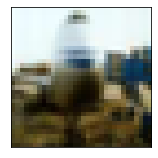

label: airplane confidence: 0.98980546

With  thermometer_encoding defense applied

BEFORE DEFENSE


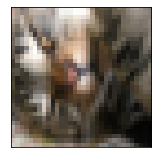

label: cat confidence: 0.62254846

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.97 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95

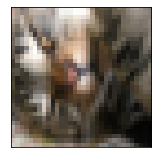

label: cat confidence: 0.62254846

With  variance_minimization defense applied

BEFORE DEFENSE


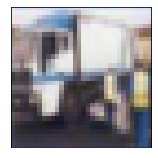

label: truck confidence: 0.9998945

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.97 
               precision    recall  f1-score   support

           0       0.91      1.00      0.9

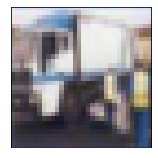

label: truck confidence: 0.9998945

With  reverse_sigmoid defense applied

BEFORE DEFENSE


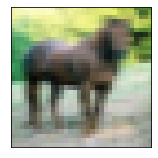

label: horse confidence: 0.98557013

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.97 
               precision    recall  f1-score   support

           0       0.91      1.00      0.

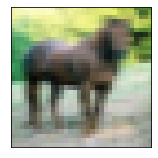

label: horse confidence: 0.31256238

With  rounded defense applied

BEFORE DEFENSE


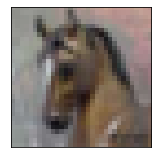

label: horse confidence: 0.99986064

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.97 
               precision    recall  f1-score   support

           0       0.91      1.00      0.

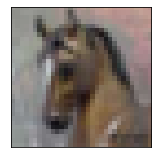

label: horse confidence: 1.0

With  adversarial_trainer_madry_pgd defense applied

BEFORE DEFENSE


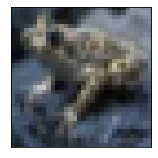

label: frog confidence: 0.9991872

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.97 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95

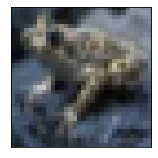

label: frog confidence: 0.9991872

With  evasion defense applied

BEFORE DEFENSE


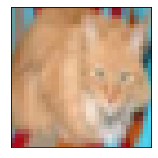

label: cat confidence: 0.9997204

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.97 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95 

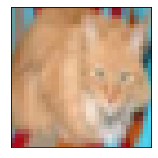

label: cat confidence: 0.9997204

With  0, std=1 defense applied

BEFORE DEFENSE


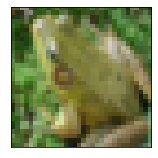

label: frog confidence: 0.9998198

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.97 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95

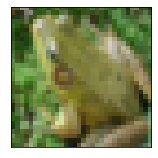

label: frog confidence: 0.9998198

With  0, std=1 defense applied

BEFORE DEFENSE


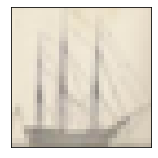

label: ship confidence: 0.99897397

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.97 
               precision    recall  f1-score   support

           0       0.91      1.00      0.9

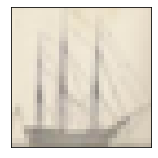

label: ship confidence: 0.99897397


In [ ]:
from art.attacks.evasion import HopSkipJump

hop_skip_jump = HopSkipJump(classifier=classifier,max_iter=5,max_eval=1000)
hop_skip_jump_targeted = HopSkipJump(classifier=classifier,max_iter=5,max_eval=1000,targeted=True)


perform_attack(hop_skip_jump, defenses)
print('                                                 TARGETED ATTACK                                                ')
perform_attack(hop_skip_jump_targeted, defenses)

Threshold attack

In [ ]:
!pip install cma

     |████████████████████████████████| 269 kB 4.2 MB/s 


In [ ]:
from art.attacks.evasion import ThresholdAttack

threshold_attack = ThresholdAttack(classifier=classifier,th=.01)
threshold_attack_targeted = ThresholdAttack(classifier=classifier,th=.01,targeted=True)


perform_attack(threshold_attack, defenses)
print('                                                 TARGETED ATTACK                                                ')
perform_attack(threshold_attack_targeted, defenses)

KeyboardInterrupt: ignored

Pixel Attack

In [ ]:
from art.attacks.evasion import PixelAttack

pixel_attack = PixelAttack(classifier=classifier,th=1)
pixel_attack_targeted = PixelAttack(classifier=classifier,th=1,targeted=True)

perform_attack(pixel_attack, defenses)
print('                                                 TARGETED ATTACK                                                ')
perform_attack(pixel_attack_targeted, defenses)

KeyboardInterrupt: ignored

Spatial Transformation attack

Spatial transformation:   0%|          | 0/1 [00:00<?, ?it/s]


Attack effects on image

Before


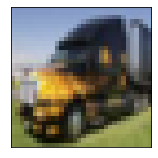

label: truck confidence: 0.9995741

After


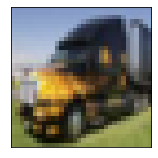

label: truck confidence: 0.9995741

Before


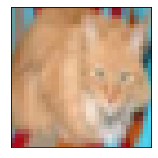

label: cat confidence: 0.9997204

After


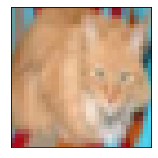

label: cat confidence: 0.9997204

Before


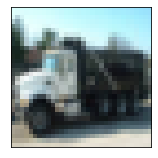

label: truck confidence: 0.99999475

After


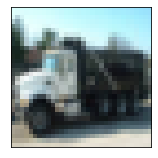

label: truck confidence: 0.99999475

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

performance on adversarial examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0   

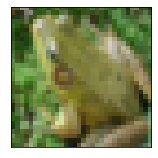

label: frog confidence: 0.9998198

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91

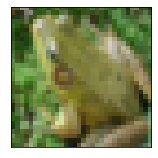

label: frog confidence: 0.9998198

With  label_smoothing defense applied

BEFORE DEFENSE


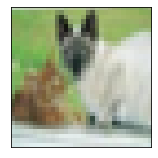

label: cat confidence: 0.9339586

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91 

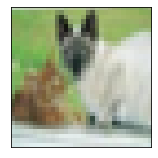

label: cat confidence: 0.9339586

With  class_labels defense applied

BEFORE DEFENSE


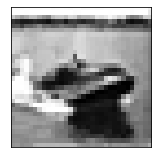

label: ship confidence: 0.99965477

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18 

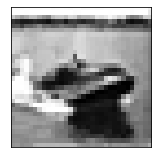

label: ship confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


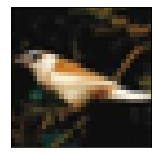

label: bird confidence: 0.99927574

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18 

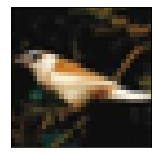

label: airplane confidence: 0.0

With  feature_squeezing defense applied

BEFORE DEFENSE


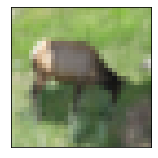

label: deer confidence: 0.9998647

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91

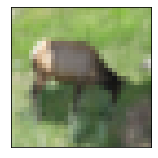

label: deer confidence: 0.9998647

With  spatial_smoothing defense applied

BEFORE DEFENSE


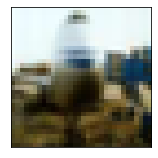

label: airplane confidence: 0.98980546

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00     

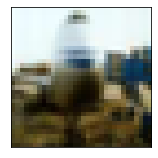

label: airplane confidence: 0.98980546

With  thermometer_encoding defense applied

BEFORE DEFENSE


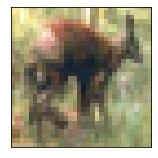

label: deer confidence: 0.9998934

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91

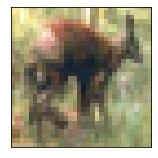

label: deer confidence: 0.9998934

With  variance_minimization defense applied

BEFORE DEFENSE


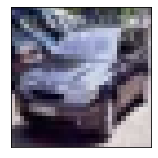

label: automobile confidence: 0.99983346

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00   

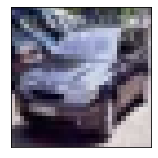

label: automobile confidence: 0.99983346

With  reverse_sigmoid defense applied

BEFORE DEFENSE


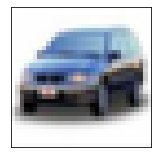

label: automobile confidence: 0.9999989

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00    

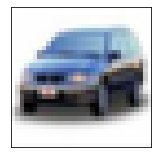

label: automobile confidence: 0.18339376

With  rounded defense applied

BEFORE DEFENSE


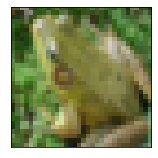

label: frog confidence: 0.9998198

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91

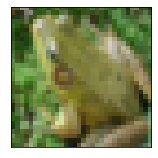

label: frog confidence: 1.0

With  adversarial_trainer_madry_pgd defense applied

BEFORE DEFENSE


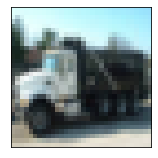

label: truck confidence: 0.99999475

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.

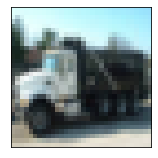

label: truck confidence: 0.99999475

With  evasion defense applied

BEFORE DEFENSE


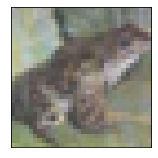

label: frog confidence: 0.99953103

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.9

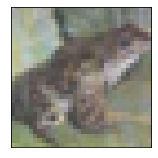

label: frog confidence: 0.99953103

With  0, std=1 defense applied

BEFORE DEFENSE


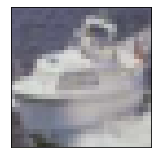

label: ship confidence: 0.99994326

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.9

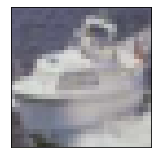

label: ship confidence: 0.99994326

With  0, std=1 defense applied

BEFORE DEFENSE


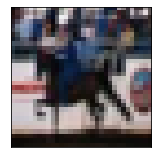

label: horse confidence: 0.99496764

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.

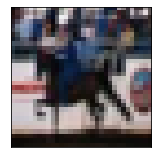

label: horse confidence: 0.99496764


In [ ]:
from art.attacks.evasion import SpatialTransformation

spatial_transformation = SpatialTransformation(classifier=classifier)

perform_attack(spatial_transformation, defenses)

Square attack

SquareAttack - restarts:   0%|          | 0/1 [00:00<?, ?it/s]

SquareAttack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]


Attack effects on image

Before


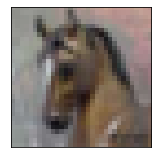

label: horse confidence: 0.99986064

After


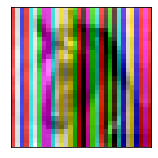

label: dog confidence: 0.91273373

Before


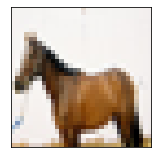

label: horse confidence: 0.9995067

After


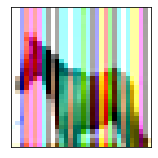

label: cat confidence: 0.8237702

Before


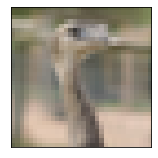

label: bird confidence: 0.9999256

After


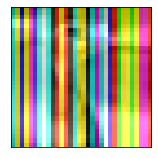

label: automobile confidence: 0.4037598

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0

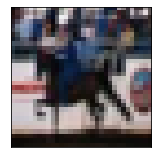

label: horse confidence: 0.99496764

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.0

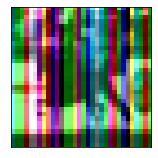

label: frog confidence: 0.8641522

With  label_smoothing defense applied

BEFORE DEFENSE


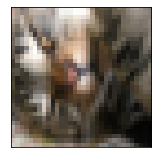

label: cat confidence: 0.62254846

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00 

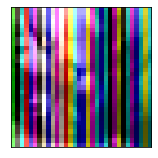

label: frog confidence: 0.97542554

With  class_labels defense applied

BEFORE DEFENSE


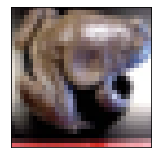

label: frog confidence: 0.98686534

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18 

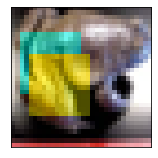

label: truck confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


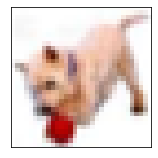

label: dog confidence: 0.9842609

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18   

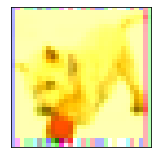

label: airplane confidence: 0.0

With  feature_squeezing defense applied

BEFORE DEFENSE


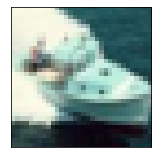

label: ship confidence: 0.999892

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00  

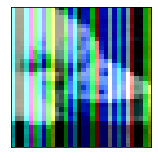

label: frog confidence: 0.8744165

With  spatial_smoothing defense applied

BEFORE DEFENSE


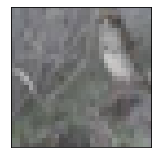

label: bird confidence: 0.98954624

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00

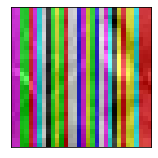

label: dog confidence: 0.96531713

With  thermometer_encoding defense applied

BEFORE DEFENSE


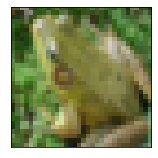

label: frog confidence: 0.9998198

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00 

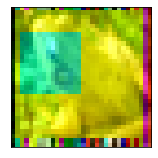

label: truck confidence: 0.6887855

With  variance_minimization defense applied

BEFORE DEFENSE


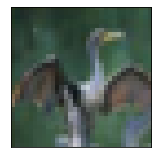

label: bird confidence: 0.9135588

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00 

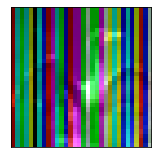

label: dog confidence: 0.8190636

With  reverse_sigmoid defense applied

BEFORE DEFENSE


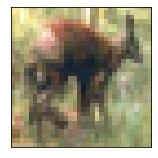

label: deer confidence: 0.9998934

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00 

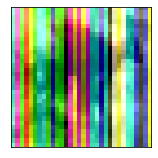

label: frog confidence: 0.28696847

With  rounded defense applied

BEFORE DEFENSE


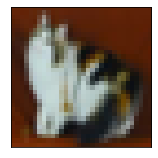

label: cat confidence: 0.99208164

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00 

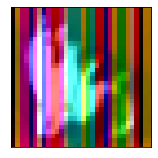

label: dog confidence: 0.84

With  adversarial_trainer_madry_pgd defense applied

BEFORE DEFENSE


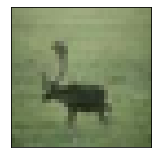

label: deer confidence: 0.9893441

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00 

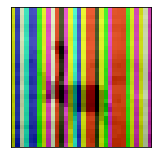

label: frog confidence: 0.99196035

With  evasion defense applied

BEFORE DEFENSE


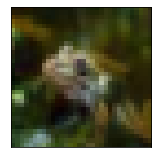

label: frog confidence: 0.9997274

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00 

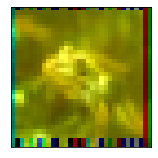

label: bird confidence: 0.51490295

With  0, std=1 defense applied

BEFORE DEFENSE


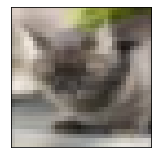

label: cat confidence: 0.99710447

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00 

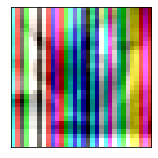

label: frog confidence: 0.8377716

With  0, std=1 defense applied

BEFORE DEFENSE


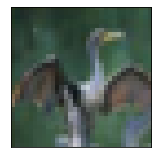

label: bird confidence: 0.9135588

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.0 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00 

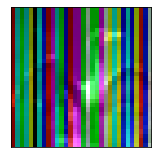

label: dog confidence: 0.8190636


In [ ]:
from art.attacks.evasion import SquareAttack
square_attack = SquareAttack(estimator=classifier)
perform_attack(square_attack, defenses)

SimBA attack


Attack effects on image

Before


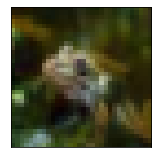

label: frog confidence: 0.9997274

After


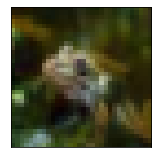

label: frog confidence: 0.9997274

Before


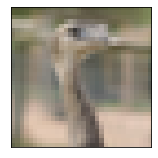

label: bird confidence: 0.9999256

After


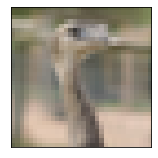

label: bird confidence: 0.9999256

Before


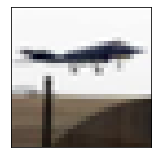

label: airplane confidence: 0.9974567

After


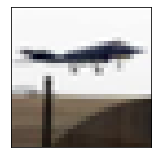

label: airplane confidence: 0.9974567

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

performance on adversarial examples:
 Accuracy: 0.94 
               precision    recall  f1-score   support

           0 

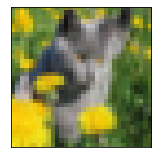

label: bird confidence: 0.6364619

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.94 
               precision    recall  f1-score   support

           0       0.82      0.90      0.86

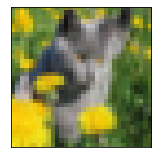

label: bird confidence: 0.6364619

With  label_smoothing defense applied

BEFORE DEFENSE


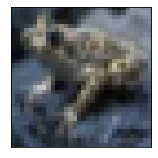

label: frog confidence: 0.9991872

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.94 
               precision    recall  f1-score   support

           0       0.82      0.90      0.86

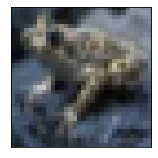

label: frog confidence: 0.9991872

With  class_labels defense applied

BEFORE DEFENSE


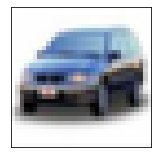

label: automobile confidence: 0.9999989

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      

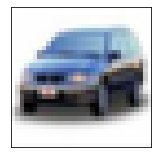

label: automobile confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


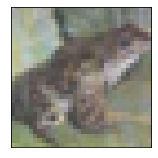

label: frog confidence: 0.99953103

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18 

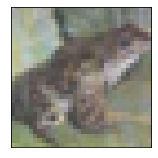

label: airplane confidence: 0.0

With  feature_squeezing defense applied

BEFORE DEFENSE


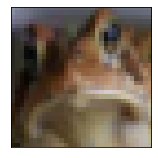

label: frog confidence: 0.9818379

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.94 
               precision    recall  f1-score   support

           0       0.82      0.90      0.86

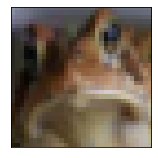

label: frog confidence: 0.9818379

With  spatial_smoothing defense applied

BEFORE DEFENSE


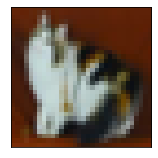

label: cat confidence: 0.99208164

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.94 
               precision    recall  f1-score   support

           0       0.82      0.90      0.86

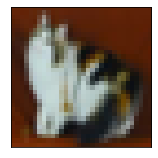

label: cat confidence: 0.99208164

With  thermometer_encoding defense applied

BEFORE DEFENSE


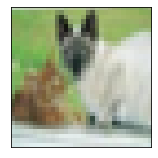

label: cat confidence: 0.9339586

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.94 
               precision    recall  f1-score   support

           0       0.82      0.90      0.86 

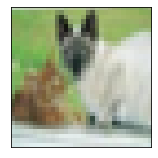

label: cat confidence: 0.9339586

With  variance_minimization defense applied

BEFORE DEFENSE


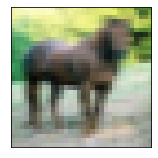

label: horse confidence: 0.98557013

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.94 
               precision    recall  f1-score   support

           0       0.82      0.90      0.

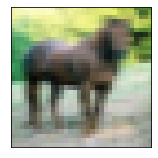

label: horse confidence: 0.98557013

With  reverse_sigmoid defense applied

BEFORE DEFENSE


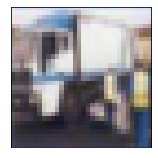

label: truck confidence: 0.9998945

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.94 
               precision    recall  f1-score   support

           0       0.82      0.90      0.8

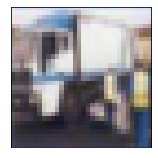

label: truck confidence: 0.22604918

With  rounded defense applied

BEFORE DEFENSE


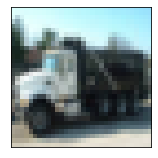

label: truck confidence: 0.99999475

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.

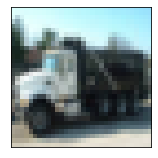

label: truck confidence: 1.0

With  adversarial_trainer_madry_pgd defense applied

BEFORE DEFENSE


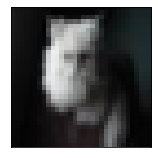

label: cat confidence: 0.9687347

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.94 
               precision    recall  f1-score   support

           0       0.82      0.90      0.86 

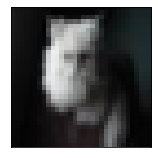

label: cat confidence: 0.9687347

With  evasion defense applied

BEFORE DEFENSE


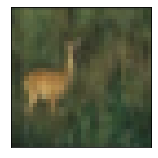

label: deer confidence: 0.99988663

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.94 
               precision    recall  f1-score   support

           0       0.82      0.90      0.8

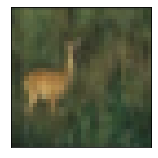

label: deer confidence: 0.99988663

With  0, std=1 defense applied

BEFORE DEFENSE


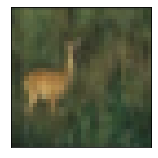

label: deer confidence: 0.99988663

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.94 
               precision    recall  f1-score   support

           0       0.82      0.90      0.8

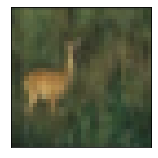

label: deer confidence: 0.99988663

With  0, std=1 defense applied

BEFORE DEFENSE


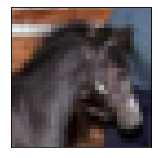

label: horse confidence: 0.995503

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.94 
               precision    recall  f1-score   support

           0       0.82      0.90      0.86

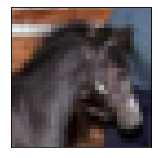

label: horse confidence: 0.995503


In [ ]:
from art.attacks.evasion import SimBA
simba_attack = SimBA(classifier=classifier)
perform_attack(simba_attack, defenses)

Boundary Attack/Decison-based attack

Boundary attack:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/5000 [00:00<?, ?it/s]


Attack effects on image

Before


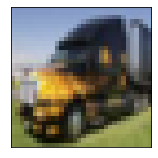

label: truck confidence: 0.9995741

After


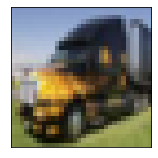

label: truck confidence: 0.9995741

Before


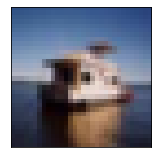

label: ship confidence: 0.9676307

After


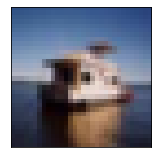

label: ship confidence: 0.9676307

Before


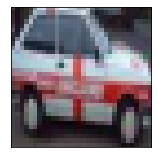

label: automobile confidence: 0.9600528

After


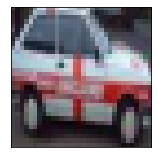

label: automobile confidence: 0.9600528

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

performance on adversarial examples:
 Accuracy: 0.96 
               precision    recall  f1-score   support

           

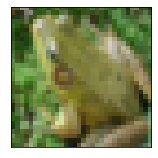

label: frog confidence: 0.9998198

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.96 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95

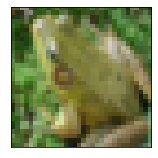

label: frog confidence: 0.9998198

With  label_smoothing defense applied

BEFORE DEFENSE


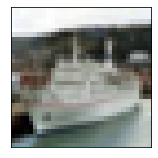

label: ship confidence: 0.9999701

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.96 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95

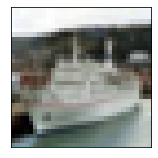

label: ship confidence: 0.9999701

With  class_labels defense applied

BEFORE DEFENSE


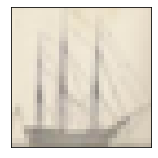

label: ship confidence: 0.99897397

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18 

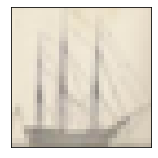

label: ship confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


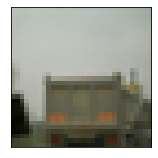

label: truck confidence: 0.7014935

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18 

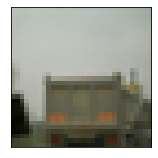

label: airplane confidence: 0.0

With  feature_squeezing defense applied

BEFORE DEFENSE


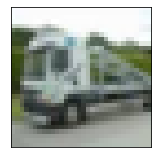

label: truck confidence: 0.9996532

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.96 
               precision    recall  f1-score   support

           0       0.91      1.00      0.9

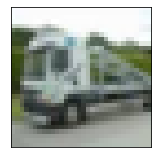

label: truck confidence: 0.9996532

With  spatial_smoothing defense applied

BEFORE DEFENSE


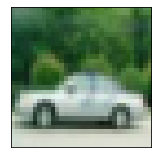

label: automobile confidence: 0.9998956

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.96 
               precision    recall  f1-score   support

           0       0.91      1.00    

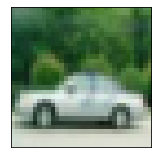

label: automobile confidence: 0.9998956

With  thermometer_encoding defense applied

BEFORE DEFENSE


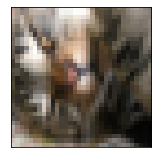

label: cat confidence: 0.62254846

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.96 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95

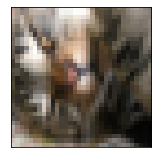

label: cat confidence: 0.62254846

With  variance_minimization defense applied

BEFORE DEFENSE


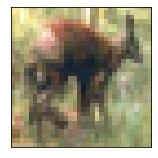

label: deer confidence: 0.9998934

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.96 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95

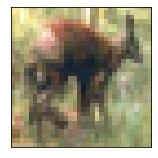

label: deer confidence: 0.9998934

With  reverse_sigmoid defense applied

BEFORE DEFENSE


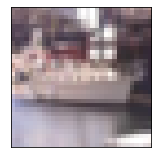

label: ship confidence: 0.9374856

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.96 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95

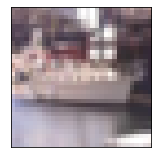

label: ship confidence: 0.35907087

With  rounded defense applied

BEFORE DEFENSE


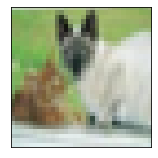

label: cat confidence: 0.9339586

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91 

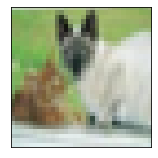

label: cat confidence: 0.93

With  adversarial_trainer_madry_pgd defense applied

BEFORE DEFENSE


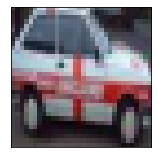

label: automobile confidence: 0.9600528

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.96 
               precision    recall  f1-score   support

           0       0.91      1.00    

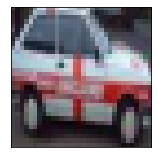

label: automobile confidence: 0.9600528

With  evasion defense applied

BEFORE DEFENSE


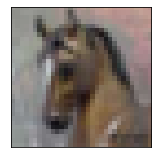

label: horse confidence: 0.99986064

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.96 
               precision    recall  f1-score   support

           0       0.91      1.00      0.

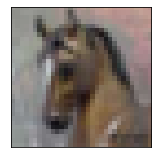

label: horse confidence: 0.99986064

With  0, std=1 defense applied

BEFORE DEFENSE


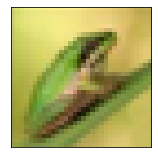

label: frog confidence: 0.9998716

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.96 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95

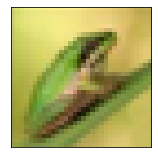

label: frog confidence: 0.9998716

With  0, std=1 defense applied

BEFORE DEFENSE


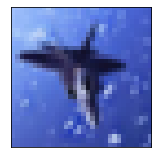

label: airplane confidence: 0.999987

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.96 
               precision    recall  f1-score   support

           0       0.91      1.00      0

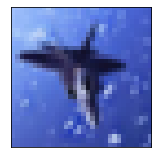

label: airplane confidence: 0.999987


In [ ]:
from art.attacks.evasion import BoundaryAttack
bound_attack = BoundaryAttack(estimator=classifier)
perform_attack(bound_attack, defenses)

Geometric Decision-based attack

GeoDA - samples:   0%|          | 0/100 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]

GeoDA - steps:   0%|          | 0/9 [00:00<?, ?it/s]


Attack effects on image

Before


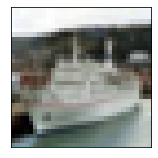

label: ship confidence: 0.9999701

After


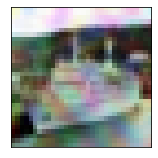

label: airplane confidence: 0.54576474

Before


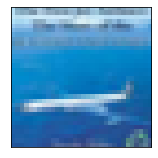

label: airplane confidence: 0.9935533

After


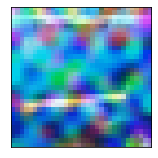

label: frog confidence: 0.48254064

Before


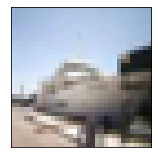

label: airplane confidence: 0.7270753

After


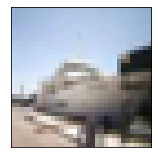

label: airplane confidence: 0.7270753

Performance w/ No Defense
performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

performance on adversarial examples:
 Accuracy: 0.01 
               precision    recall  f1-score   support

           0 

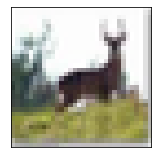

label: deer confidence: 0.99752337

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.01 
               precision    recall  f1-score   support

           0       0.05      0.10      0.0

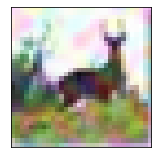

label: dog confidence: 0.37802142

With  label_smoothing defense applied

BEFORE DEFENSE


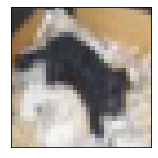

label: cat confidence: 0.9383735

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.01 
               precision    recall  f1-score   support

           0       0.05      0.10      0.06 

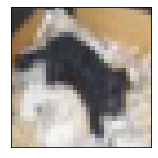

label: cat confidence: 0.9383735

With  class_labels defense applied

BEFORE DEFENSE


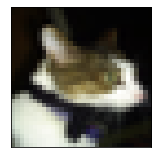

label: cat confidence: 0.99184376

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18  

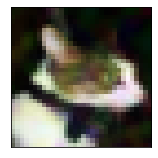

label: frog confidence: 1.0

With  high_confidence defense applied

BEFORE DEFENSE


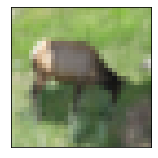

label: deer confidence: 0.9998647

Performance on originals examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

Performance on adversarial examples:
 Accuracy: 0.1 
               precision    recall  f1-score   support

           0       0.10      1.00      0.18  

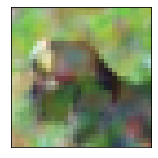

label: airplane confidence: 0.0

With  feature_squeezing defense applied

BEFORE DEFENSE


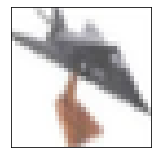

label: airplane confidence: 0.99961156

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.01 
               precision    recall  f1-score   support

           0       0.05      0.10     

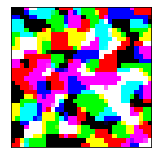

label: airplane confidence: 0.5724812

With  spatial_smoothing defense applied

BEFORE DEFENSE


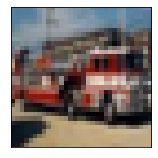

label: truck confidence: 0.9999064

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.01 
               precision    recall  f1-score   support

           0       0.05      0.10      0.0

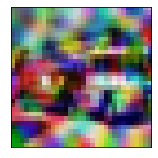

label: automobile confidence: 0.45620415

With  thermometer_encoding defense applied

BEFORE DEFENSE


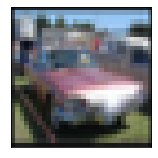

label: automobile confidence: 0.99996984

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.01 
               precision    recall  f1-score   support

           0       0.05      0.10   

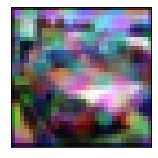

label: airplane confidence: 0.36058038

With  variance_minimization defense applied

BEFORE DEFENSE


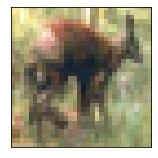

label: deer confidence: 0.9998934

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.01 
               precision    recall  f1-score   support

           0       0.05      0.10      0.06

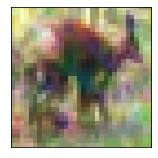

label: bird confidence: 0.40097663

With  reverse_sigmoid defense applied

BEFORE DEFENSE


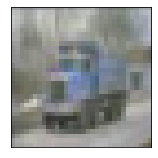

label: truck confidence: 0.99986684

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.01 
               precision    recall  f1-score   support

           0       0.05      0.10      0.

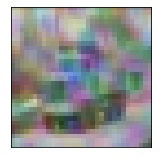

label: bird confidence: 0.16283767

With  rounded defense applied

BEFORE DEFENSE


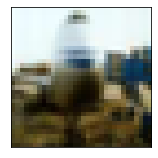

label: airplane confidence: 0.98980546

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.08 
               precision    recall  f1-score   support

           0       0.16      0.40     

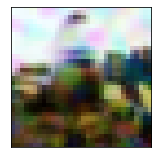

label: bird confidence: 0.48

With  adversarial_trainer_madry_pgd defense applied

BEFORE DEFENSE


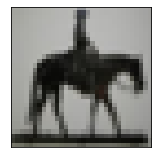

label: horse confidence: 0.9993476

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.01 
               precision    recall  f1-score   support

           0       0.05      0.10      0.0

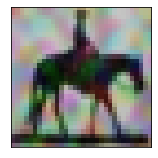

label: airplane confidence: 0.39908385

With  evasion defense applied

BEFORE DEFENSE


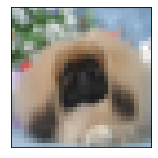

label: dog confidence: 0.9993801

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.01 
               precision    recall  f1-score   support

           0       0.05      0.10      0.06 

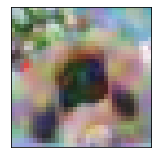

label: deer confidence: 0.43915522

With  0, std=1 defense applied

BEFORE DEFENSE


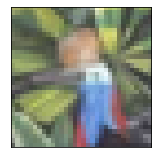

label: bird confidence: 0.99915814

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.01 
               precision    recall  f1-score   support

           0       0.05      0.10      0.0

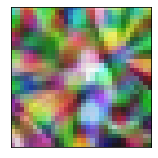

label: frog confidence: 0.51120967

With  0, std=1 defense applied

BEFORE DEFENSE


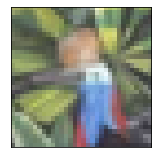

label: bird confidence: 0.99915814

Performance on originals examples:
 Accuracy: 0.95 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       0.90      0.90      0.90        10
           4       1.00      1.00      1.00        10
           5       0.90      0.90      0.90        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Performance on adversarial examples:
 Accuracy: 0.01 
               precision    recall  f1-score   support

           0       0.05      0.10      0.0

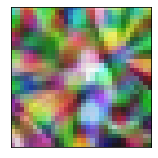

label: frog confidence: 0.51120967


In [ ]:
from art.attacks.evasion import GeoDA
geo_attack = GeoDA(estimator=classifier)
perform_attack(geo_attack, defenses)

In [ ]:
from art.estimators.classification import QueryEfficientGradientEstimationClassifier
que_attack = QueryEfficientGradientEstimationClassifier(classifier=classifier,num_basis = int, sigma = float, round_samples = 0.0)
perform_attack(que_attack, defenses)

AttributeError: ignored